# Training Pytorch models with TVM computation

a tutorial by Thomas Viehmann <tv@lernapparat.de>


Acknowledgement & Disclosure: The creation of this tutorial was sponsored by AMD. Thank you!

Following our tutorial on running and tuning PyTorch models on TVM, we can look at using TVM to speed up training, too. Of course, this opens an entire new can of worms as we need to deal with autodifferentiation.

Our goal in this tutorial is to take a non-trivial module (we'll use BertLayer from HuggingFace transformer's BertModel) and divert the computation during training to TVM.
So the user can take a (traceable) module and do
```
add_tvm_dispatch(module, sample_input)
```
and then if she calls module with inputs of the same shape as the sample_input, she'll get the outputs computed by TVM (as PyTorch tensors, of course) and if not, it'll just use the regular forward.

The bad new first: This tutorial shows how to do these things. We will not yet achieve a great speedup in this tutorial.

But enough talk, let us dive right in!

The first thing to do is import things and get the model we want.

In [1]:
import inspect
import types
import sys

# I sometimes need to choose PyTorch...
#sys.path.insert(0, '/home/tv/pytorch/pytorch/build/lib.linux-x86_64-3.8//')
import torch
import torch.utils.dlpack

# import TVM
import sys
import os


tvm_root = '/home/tv/rocm/tvm/tvm/'
tvm_paths = [os.path.join(tvm_root, p) for p in ['python', 'topi/python', 'nnvm/python']]
os.environ['PYTHONPATH'] = ':'.join([os.environ.get('PYTHONPATH', '')] + tvm_paths)
for p in tvm_paths:
    sys.path.insert(0, p)
    

import tvm
import tvm.relay

torch.cuda.get_device_name()


'Device 66af'

Helpfully, transformers supports tracing their model with the PyTorch JIT. We use their [tutorial on it](https://huggingface.co/transformers/torchscript.html), the following is copied straight from the tutorial

In [2]:
import transformers

from transformers import BertModel, BertTokenizer, BertConfig
import numpy

import torch

enc = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenizing input text
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = enc.tokenize(text)

# Masking one of the input tokens
masked_index = 8
tokenized_text[masked_index] = '[MASK]'
indexed_tokens = enc.convert_tokens_to_ids(tokenized_text)
segments_ids = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

# Creating a dummy input
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])
dummy_input = [tokens_tensor, segments_tensors]

# If you are instantiating the model with `from_pretrained` you can also easily set the TorchScript flag
model = BertModel.from_pretrained("bert-base-uncased", torchscript=True)

model.eval()
for p in model.parameters():
    p.requires_grad_(False)

transformers.__version__

'3.0.0'

Now we can trace our model. As we want to do inference, we impose evaluation mode and not requiring gradients for the parameters.

In [3]:
dtype = torch.float32
dtype_str = str(dtype).split('.')[-1]

In [4]:
# Creating the trace
model.to(dtype)
traced_model = torch.jit.trace(model, [tokens_tensor, segments_tensors])
traced_model.eval()
for p in traced_model.parameters():
    p.requires_grad_(False)

Readers of the PyTorch Bert & TVM tutorial will recall the wrapper we had for getting inputs and outputs of a submodule of the model.

In [5]:
class DebugWrap(torch.nn.Module):
    def __init__(self, root, target_qn):
        super().__init__()
        self.root = (root,) # Hide from PyTorch
        parent, = self.root
        target_qn = target_qn.split('.')
        self.target_basename = target_qn[-1]
        for nc in target_qn[:-1]:
            parent = getattr(parent, nc)
        self.parent = (parent,)
        target = getattr(parent, self.target_basename)
        self.wrapped = target
        setattr(parent, self.target_basename, self)
    def remove(self):
        parent, = self.parent
        setattr(parent, self.target_basename, self.wrapped)
        self.root = None
    def forward(self, *inp, **kwinp):
        assert self.root is not None
        self.DEBUG_INP = inp
        self.DEBUG_KWINP = kwinp
        out = self.wrapped(*inp, **kwinp)
        self.DEBUG_OUT = out
        return out

We also had a fancy visualization. We now have a small addition, the dictionary to specify attributes for nodes. This will come in handy later.

In [6]:
import graphviz
def visualize(expr, collapse_small=True, node_attr_dict = {}):
    def collect_ops(node):
        ops = set()
        def visitor(e):
            if isinstance(e, tvm.ir.Op):
                ops.add(e.name)
        tvm.relay.analysis.post_order_visit(node, visitor)
        return ops

    # node_dict maps a Relay node to an index (node ID)
    def _traverse_expr(node, node_dict):
        if node in node_dict:
            return
        node_dict[node] = len(node_dict)

    node_dict = {}
    tvm.relay.analysis.post_order_visit(expr, lambda x: _traverse_expr(x, node_dict))

    relayviz_nodes = []

    dot = graphviz.Digraph(format='svg')
    dot.attr('node', shape = 'box')

    def to_str(node):
        if isinstance(node, tvm.relay.Constant):
            return repr(node).lstrip('Constant(')[:-1]
        else:
            raise NotImplementedError("to_str:" + repr(node))

    def is_small_const(c):
        if not (collapse_small and isinstance(c, tvm.relay.Constant)):
            return False
        if isinstance(c.data, tvm.runtime.ndarray.NDArray):
            return numpy.prod(c.data.shape) < 10
        return True
            
    # Sort by node ID
    for node, node_id in sorted(node_dict.items(), key=lambda x: x[1]):
        if isinstance(node, tvm.relay.Function):
            dot.node(str(node_id), 'Function', **node_attr_dict.get(node, {}))
            dot.edge(str(node_dict[node.body]), str(node_id))
        elif isinstance(node, tvm.relay.Var):
            if node.type_annotation is not None:
                if hasattr(node.type_annotation, 'shape'):
                    shape = tuple([int(x) for x in node.type_annotation.shape])
                    dtype = node.type_annotation.dtype
                    typstr = 'Tensor[{}, {}]'.format(shape, dtype)
                else:
                    typstr = str(node.type_annotation)
            else:
                typstr = '?'
            d = dict(shape = 'ellipse')
            d.update(node_attr_dict.get(node, {}))
            dot.node(str(node_id),
                     '{}: {}'.format(
                         node.name_hint, typstr
                     ), **d)
        elif isinstance(node, tvm.relay.Tuple):
            dot.node(str(node_id), 'Tuple[...])', **node_attr_dict.get(node, {}))
            for field in node.fields:
                dot.edge(str(node_dict[field]), str(node_id))
        elif isinstance(node, tvm.relay.Constant):
            
            if not is_small_const(node): # small consts are shown in ops
                dot.node(str(node_id), 'Constant({}, {})'.format(node.data.shape, node.data.dtype),
                        **node_attr_dict.get(node, {}))
        elif isinstance(node, tvm.relay.Call):
            args_with_edge = []
            arg_str_list = []
            for arg in node.args:
                if is_small_const(arg):
                    arg_str_list.append(to_str(arg))
                else:
                    arg_str_list.append('·')
                    args_with_edge.append(arg)
            arg_str = ', '.join(arg_str_list)
            if isinstance(node.op, tvm.ir.Op):
                name = node.op.name
                attrs = {k:getattr(node.attrs, k) for k in node.attrs.keys()} if hasattr(node.attrs, 'keys') else {}
                #attrs = inspect.getmembers(node.attrs)
                attr_str_list = [k+'='+(str(v) if len(str(v))<15 else "...") for k, v in attrs.items()]
                if attr_str_list:
                    attr_str = '| '+ ', '.join(attr_str_list)
                else:
                    attr_str = ''
            else:
                ops = collect_ops(node)
                if ops:
                    name = '_'.join(ops)
                else:
                    name = '...'
                attr_str = ''
            s = f'{name}({arg_str}{attr_str})'
            dot.node(str(node_id), s, **node_attr_dict.get(node, {}))
            for arg in args_with_edge:
                dot.edge(str(node_dict[arg]), str(node_id))
        elif isinstance(node, tvm.ir.Op):
            # dot.node(str(node_id), 'Op {}'.format(node.name))
            pass # covered in call
        elif isinstance(node, tvm.relay.TupleGetItem):
            dot.node(str(node_id), 'TupleGetItem(idx={})'.format(node.index), **node_attr_dict.get(node, {}))
            dot.edge(str(node_dict[node.tuple_value]), str(node_id))
        elif isinstance(node, tvm.relay.Let):
            dot.node(str(node_id), 'Let(XX)', **node_attr_dict.get(node, {}))
            dot.edge(str(node_dict[node.value]), str(node_id))
            dot.edge(str(node_id), str(node_dict[node.var]))
        else:
            raise RuntimeError(
                'Unknown node type. node_id: {}, node: {}'.format(node_id, type(node)))

    return dot

Let's wrap the first BertLayer in our model. You could also take smaller bits if you run my tutorials on your phone and want smaller graphs.

In [7]:
try:
    debug_wrap = DebugWrap(model, "encoder.layer.0") # encoder.layer.0.attention.self
    tt = tokens_tensor.cpu()
    st = segments_tensors.cpu()
    model(tt, st)
finally:
    debug_wrap.remove()

We trace the module.

In [8]:
model.train()
traced_module = torch.jit.trace(debug_wrap.wrapped, [i.to(dtype) for i in debug_wrap.DEBUG_INP[:2]])

/usr/local/lib/python3.8/dist-packages/torch/jit/_trace.py:954: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
With rtol=1e-05 and atol=1e-05, found 10750 element(s) (out of 10752) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference was 2.075359344482422 (-4.184629917144775 vs. -2.1092705726623535), which occurred at index (0, 6, 381).
  _check_trace(


Let's convert the traced model to TVM. This works just as before.

In [9]:
shape_list = [(i.debugName().split('.')[0], i.type().sizes()) for i in  list(traced_module.graph.inputs())[1:]]
mod, mod_params = tvm.relay.frontend.from_pytorch(traced_module, shape_list, default_dtype=dtype_str)

ANTLR runtime and generated code versions disagree: 4.8!=4.7.2
ANTLR runtime and generated code versions disagree: 4.8!=4.7.2


One thing we'll do in between is to move from a module interface - with named parameters - to a functional
interface (which is what TVM can do for us). The first thing we want to do for that is arrange for the function arguments to be in an order that we can work with - i.e. first the direct inputs to the module and then the parameters in the same order that PyTorch uses them.

In [10]:
# the converter will output arguments in an arbitrary order (well, by position of use), we want that of the input
fn = mod['main']
# Careful traced module's vs. non-traced module's parameter ordering.
# Anecdotally, I have not seen orderings differ between the two, though.
arg_order = ([n for n, _ in shape_list]
             +[n for n, _ in traced_module.named_parameters()])
tmp_arg_idx = {p.name_hint: i for i, p in enumerate(fn.params)}

fn = tvm.relay.Function([fn.params[tmp_arg_idx[n]] for n in arg_order], fn.body)

Let's look at our function.

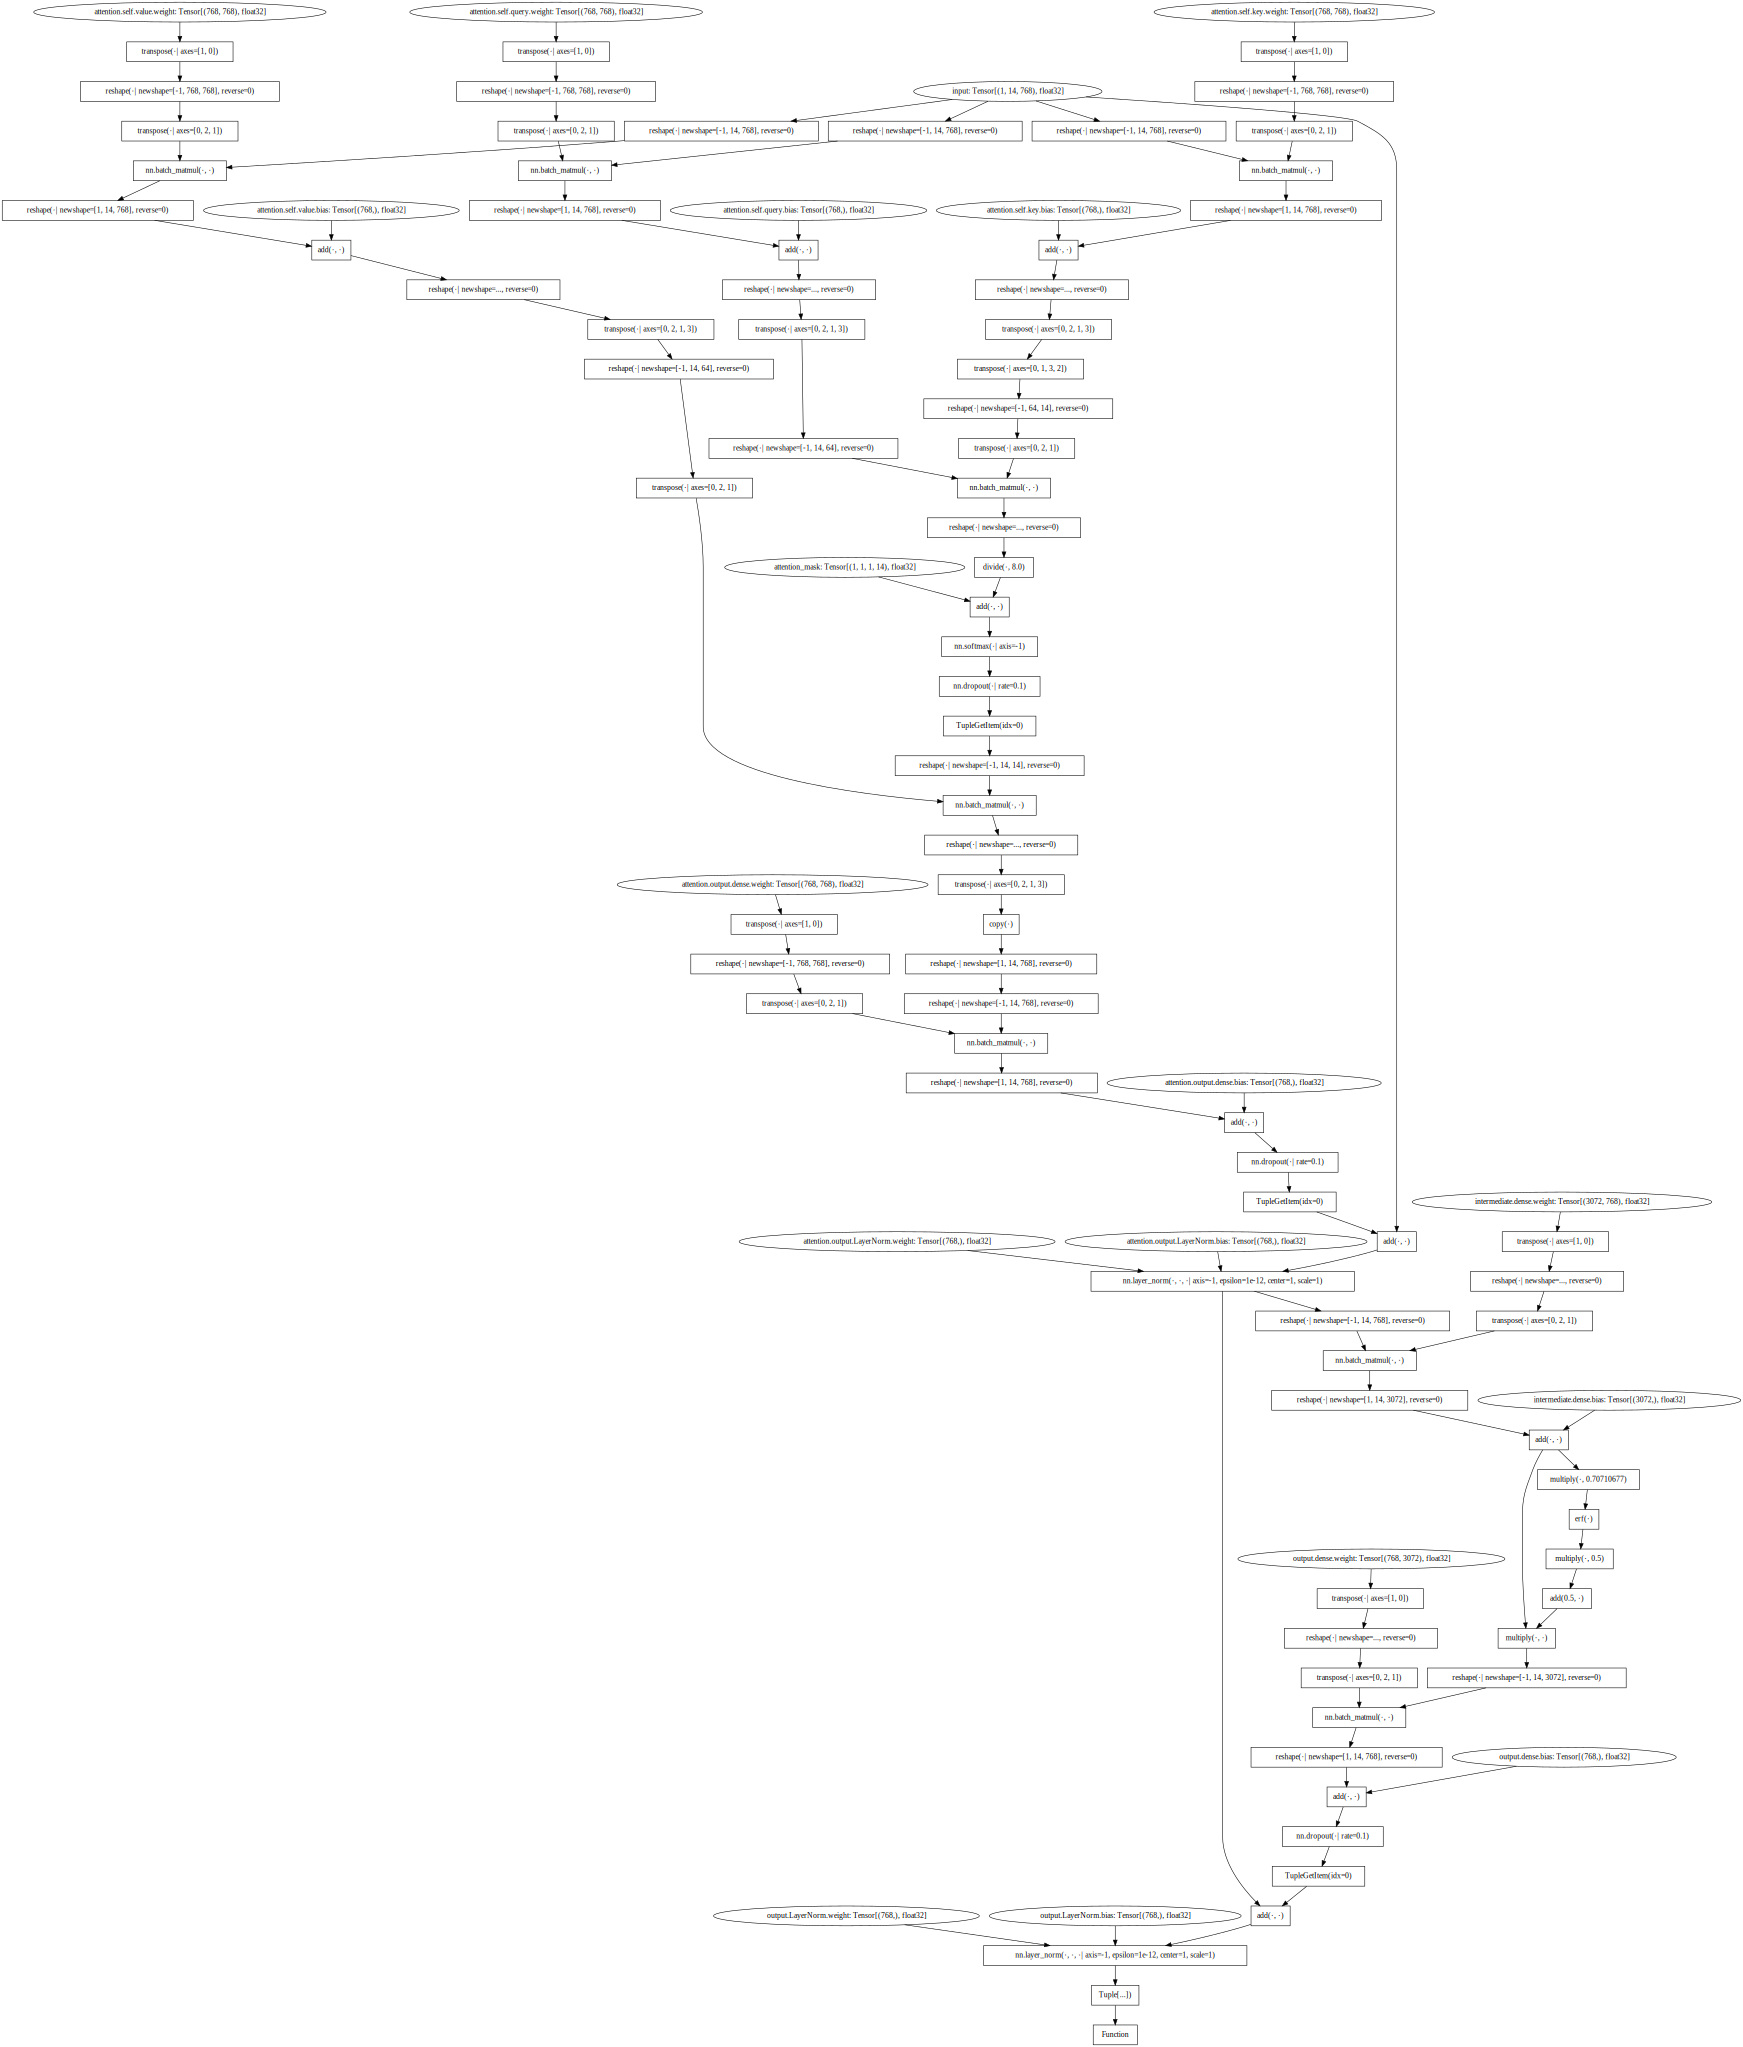

In [11]:
visualize(fn)

As in the BERT inference, we want to run some optimization passes.
It'll be convenient to do this on at a function level, so we're wrapping some standard TVM passes to work like this, too.

We already know the `ShapeConstDedupMutator` and the `TransposeDedupMutator` from the inference notebook, deduplicating some of the things that came with the PyTorch conversion.

But we also have a few new transformations:

- One particularity of the Autodifferentiation is that it'll use a lot of `..._like` operations to broadcast or "unbroadcast" (summation is the dual of broadcasting w.r.t. autodifferentiation) things. But this means that you now have two tensor arguments, even if the latter doesn't really need a gradient. `ZappLike` replaces those operations with the corresponding functions taking a shape parameter instead.
- Another thing is the "rooting" of derivatives. TVM generates a tensors with all ones of the same shape as the return values of our function as the starting point for the chain rule. These are then multiplied to the derivatives of our operations. But multiplication with ones is not doing much, so we strike that. Similarly, TVM initializes the gradient of a variable (an input) to zeros of the same shape. If it isn't used, the gradient will be zero, but if it is, the "real gradient" will be added to that zero. But adding zero can be eliminated as well. These are taken care off by ZeroZapp and OneZapp.
- TVM doesn't have a training variant for the `LayerNorm` (or `BatchNorm` or others). So we implement a pass to spell out the computation.
- TVM also doesn't have training dropout. Here the problem is somewhat harder to fix, as TVM doesn't have random currently. We instead replace the dropout by a construct taking a random bernoulli draw (of 0/1 values) and mimicking dropout with that. The idea is that we'll use PyTorch to generate this mask for us. This has the added benefit that (if we generate dropout masks in the same order as PyTorch) we'll get the exact same result.

So here is this bit of infrastructure:

In [12]:
import numpy

def work_on_fn(pass_cls):
    def apply_pass(fn_or_mod):
        if isinstance(fn_or_mod, tvm.IRModule):
            return pass_cls()(fn_or_mod)
        if isinstance(fn_or_mod, tvm.relay.Function):
            return pass_cls()(
                       tvm.IRModule({'main': fn_or_mod}))['main']
        raise NotImplemented("unsupporded type {}".format(type(fn_or_mod)))
    return apply_pass

infer_type = work_on_fn(tvm.relay.transform.InferType)
to_graph_normal_form = work_on_fn(tvm.relay.transform.ToGraphNormalForm)
dead_code_elimination = work_on_fn(tvm.relay.transform.DeadCodeElimination)
eliminate_common_subexpr = work_on_fn(tvm.relay.transform.EliminateCommonSubexpr)

class ShapeConstDedupMutator(tvm.relay.ExprMutator):
    def __init__(self):
        super().__init__()
        self.shape_consts = {}

    def visit_call(self, call):
        if (isinstance(call.op, tvm.ir.Op) 
            and call.op.name in {"reshape", "broadcast_to", "collapse_sum_to"}
            and isinstance(call.args[1], tvm.relay.Constant)):
            # assert list(call.attrs.newshape) == list(call.args[1].data.asnumpy())
            new_fn = self.visit(call.op)
            new_args = [self.visit(arg) for arg in call.args]
            const = new_args[1]
            assert const.data.dtype.startswith('int') and len(const.data.shape)==1
            key = tuple(const.data.asnumpy())
            if key in self.shape_consts:
                new_args[1] = self.shape_consts[key]
            else:
                self.shape_consts[key] = new_args[1]
            return tvm.relay.Call(new_fn, new_args, call.attrs)
        return super().visit_call(call)


class TransposeDedupMutator(tvm.relay.ExprMutator):
    def visit_call(self, call):
        if (isinstance(call.op, tvm.ir.Op) and call.op.name == "transpose"
            and isinstance(call.args[0], tvm.relay.Call) 
            and isinstance(call.args[0].op, tvm.ir.Op) and call.args[0].op.name == "transpose"):
            axes = [call.args[0].attrs.axes[int(i)] for i in call.attrs.axes]
            new_inp = self.visit(call.args[0].args[0])
            if axes == list(range(len(axes))): # neutral permutation, should really do this separately...
                return new_inp
            return tvm.relay.transpose(new_inp, axes)
        return super().visit_call(call)

#@tvm.relay.transform.function_pass(opt_level=1)
#def TransposeDedup(fn, mod, ctx):
#    return TransposeDedupMutator().visit(fn)

class ZeroZapp(tvm.relay.dataflow_pattern.DFPatternCallback):
    def __init__(self):
        self.zeros = tvm.relay.dataflow_pattern.is_op("zeros")(tvm.relay.dataflow_pattern.wildcard())
        self.other_tensor = tvm.relay.dataflow_pattern.wildcard()
        self.pattern = (self.zeros + self.other_tensor) | (self.other_tensor + self.zeros)

    def callback(self, pre, post, node_map):
        rt = node_map[self.pattern][0]
        ot = node_map[self.other_tensor][0]
        if (ot._checked_type_ == rt._checked_type_):
            return ot
        else:
            return tvm.relay.broadcast_to(ot, list(rt._checked_type_.shape))

class ZeroZapp(tvm.relay.dataflow_pattern.DFPatternCallback):
    def __init__(self):
        self.ones = tvm.relay.dataflow_pattern.is_op("zeros")(tvm.relay.dataflow_pattern.wildcard()) | tvm.relay.dataflow_pattern.is_constant()
        self.other_tensor = tvm.relay.dataflow_pattern.wildcard()
        self.pattern = (self.ones + self.other_tensor) | (self.other_tensor + self.ones)

    def callback(self, pre, post, node_map):
        rt = node_map[self.pattern][0]
        ones = node_map[self.ones][0]
        ot = node_map[self.other_tensor][0]
        if isinstance(ones, tvm.relay.Constant):
            val = ones.data.asnumpy()
            if not ((val == 0) if numpy.isscalar(val) else (val == 0).all()):
                return rt
        # I don't know why I don't reliably get checked types here...
        if (((rt._checked_type_ is not None) and (ot._checked_type_ == rt._checked_type_))
            or (rt.type_args[0] == rt.type_args[1])):
            return ot
        elif (rt._checked_type_ is not None):
            return tvm.relay.broadcast_to(ot, list(rt._checked_type_.shape))
        return rt

class OneZapp(tvm.relay.dataflow_pattern.DFPatternCallback):
    def __init__(self):
        self.ones = tvm.relay.dataflow_pattern.is_op("ones")(tvm.relay.dataflow_pattern.wildcard()) | tvm.relay.dataflow_pattern.is_constant()
        self.other_tensor = tvm.relay.dataflow_pattern.wildcard()
        self.pattern = (self.ones * self.other_tensor) | (self.other_tensor * self.ones)

    def callback(self, pre, post, node_map):
        global val
        rt = node_map[self.pattern][0]
        ones = node_map[self.ones][0]
        ot = node_map[self.other_tensor][0]
        if isinstance(ones, tvm.relay.Constant):
            val = ones.data.asnumpy()
            if not ((val == 1) if numpy.isscalar(val) else (val == 1).all()):
                return rt
        if (((rt._checked_type_ is not None) and (ot._checked_type_ == rt._checked_type_))
            or (rt.type_args[0] == rt.type_args[1])):
            return ot
        if (rt._checked_type_ is not None):
            return tvm.relay.broadcast_to(ot, list(rt._checked_type_.shape))
        return rt


class LikeZapp(tvm.relay.dataflow_pattern.DFPatternCallback):
    def __init__(self):
        self.translations_with_dt = {'zeros_like': tvm.relay.zeros,
                                     'ones_like': tvm.relay.ones}
        self.data_tensor = tvm.relay.dataflow_pattern.wildcard()
        self.pattern_tensor = tvm.relay.dataflow_pattern.wildcard()
        self.pattern = ((tvm.relay.dataflow_pattern.is_op("zeros_like")
                        | tvm.relay.dataflow_pattern.is_op("ones_like")
                        )(self.data_tensor)
                        ) | ((
                        tvm.relay.dataflow_pattern.is_op("collapse_sum_like")
                        | tvm.relay.dataflow_pattern.is_op("reshape_like")
                        | tvm.relay.dataflow_pattern.is_op("broadcast_to_like")
                       )(self.data_tensor, self.pattern_tensor))

    def callback(self, pre, post, node_map):
        data = node_map[self.data_tensor][0]
        res = node_map[self.pattern][0]
        if res.op.name in self.translations_with_dt:
            ret = self.translations_with_dt[res.op.name](list(res.type_args[0].shape),
                                                              res.type_args[0].dtype) # which dtype?
            return ret
        if (res.type_args[0] is not None and res.type_args[0] == res.type_args[1]):
            return data
        if res.op.name == 'broadcast_to_like':
            return tvm.relay.broadcast_to(data, list(res.type_args[1].shape))
        if res.op.name == 'reshape_like':
            return tvm.relay.reshape(data, list(res.type_args[1].shape))
        if res.op.name == 'collapse_sum_like':
            return tvm.relay.collapse_sum_to(data, list(res.type_args[1].shape))
        return res


class DecomposeLayerNorm(tvm.relay.dataflow_pattern.DFPatternCallback):
    # TVM doesn't have a LayerNorm backward
    def __init__(self):
        self.pattern = tvm.relay.dataflow_pattern.is_op("nn.layer_norm")(
            tvm.relay.dataflow_pattern.wildcard(),
            tvm.relay.dataflow_pattern.wildcard(),
            tvm.relay.dataflow_pattern.wildcard())

    def callback(self, pre, post, node_map):
        # probably only 1d...
        res = node_map[self.pattern][0]
        inp, weight, bias = res.args
        mean = tvm.relay.mean(inp, axis=res.attrs.axis, keepdims=True)
        std = tvm.relay.std(inp, axis=res.attrs.axis, keepdims=True)
        res_new = ((inp - mean) / (std + tvm.relay.const(res.attrs.epsilon, dtype=res.type_args[0].dtype))) * weight + bias
        return res_new

class ExternalizeDropout(tvm.relay.dataflow_pattern.DFPatternCallback):
    # TVM doesn't have a Dropout defined (for inference it can be deleted)
    # but it also does not appear to have random, so we make the random draw
    # an input
    def __init__(self):
        self.dropout_info = {}
        self.counter = 0
        self.inp = tvm.relay.dataflow_pattern.wildcard()
        self.dropout = tvm.relay.dataflow_pattern.is_op("nn.dropout")(self.inp)
        self.pattern = tvm.relay.dataflow_pattern.is_tuple_get_item(self.dropout, 0)

    def callback(self, pre, post, node_map):
        res = node_map[self.pattern][0]
        dropout = node_map[self.dropout][0]
        inp = node_map[self.inp][0]
        typ = dropout.type_args[0]
        rate = dropout.attrs.rate
        name = f"dropout:{self.counter}"
        self.counter += 1
        do_var = tvm.relay.var(name, type_annotation=typ)
        self.dropout_info[name] = (rate, typ)
        return inp * (do_var * tvm.relay.const(1 / (1 - rate), dtype=typ.dtype))

def externalize_dropout(fn):
    edo = ExternalizeDropout()
    fn = tvm.relay.dataflow_pattern.rewrite(edo, fn)
    return fn, edo.dropout_info



As hinted at above, TVM's gradient taking assumes that it is the last element in the computation (the ones-Tensors discussed above). This isn't a good fit with PyTorch's modular view which expects a `grad_out` for each output to be given. Happily, this is computationally equivalent to multiplying by grad out and summation, so we amend our function with that. We wish to be flexible, so we allow both functions returning a single tensor and those returning a tuple of tensors.
Also we apply the passes handling layer norm and the dropout .

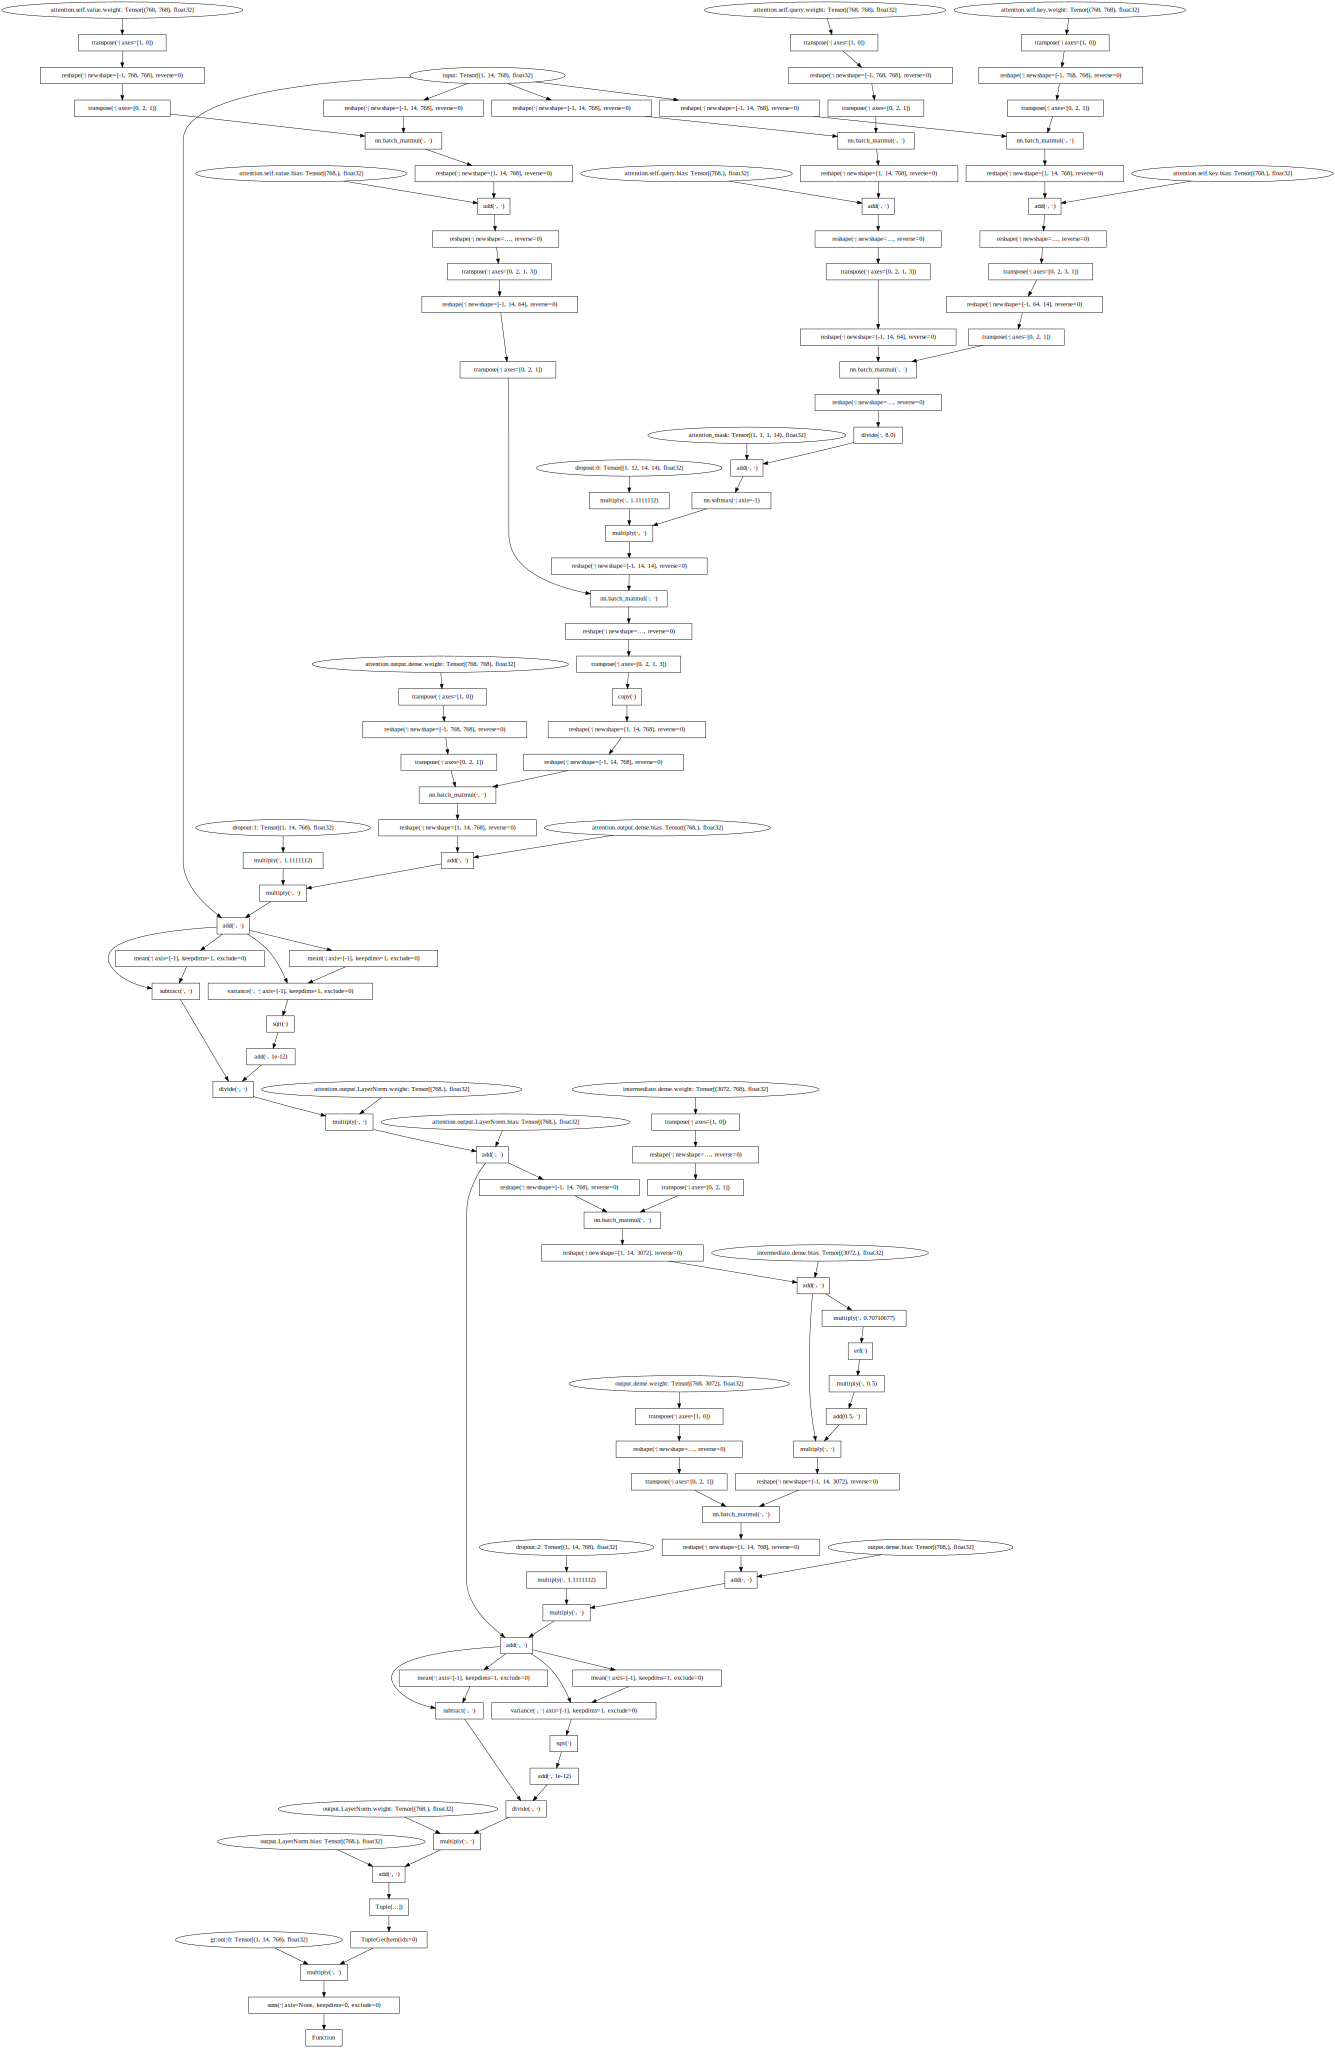

In [14]:
fn = TransposeDedupMutator().visit(fn)
fn = infer_type(fn)
output_type = fn.body.checked_type

if isinstance(output_type, tvm.relay.TensorType):
    gr_out = tvm.relay.var("gr:out", output_type)
    fn_for_gr = tvm.relay.Function(list(fn.params) + [gr_out], tvm.relay.sum(fn.body * gr_out))
else:
    # we can try to handle tuples of tensors, but our nesting patience ends there
    assert (isinstance(output_type, tvm.relay.TupleType) and
            all([isinstance(f, tvm.relay.TensorType) for f in output_type.fields]))
    gr_outs = [tvm.relay.var(f"gr:out:{i}", t) for i, t in enumerate(output_type.fields)]
    prods_with_gr_out = [tvm.relay.sum(tvm.relay.TupleGetItem(fn.body, i) * go_i)
                         for i, go_i in enumerate(gr_outs)]
    s = prods_with_gr_out[0]
    for p in prods_with_gr_out[1:]:
        s = s + p
    fn_for_gr = tvm.relay.Function(list(fn.params) + gr_outs, s)
fn_for_gr = infer_type(fn_for_gr)
fn_for_gr = tvm.relay.dataflow_pattern.rewrite(DecomposeLayerNorm(), fn_for_gr)
fn_for_gr = infer_type(fn_for_gr)
fn_for_gr, dropout_info = externalize_dropout(fn_for_gr)
fn_for_gr = infer_type(fn_for_gr)

visualize(fn_for_gr)

Finally we can take the grad. As we get a lot of `let` nodes, we bring it to normal form.

In [15]:
grfn = tvm.relay.transform.gradient(fn_for_gr, mode='first_order')
grfn = to_graph_normal_form(grfn)

TVM's gradient-taking returns a function that has the same parameters as the original function (in our case amended with the `grad_out` and dropout) and then returns a tuple of the original return and a tuple containing gradients for all inputs.
The first thing we do is to drop all the gradients for `grad_out` and `dropout` which we don't need.
Then we run our simplification passes.

In [16]:
# Now we have (sum(orig_out * grad_out), (grad_inp_1, ..., grad_inp_n, grad_grad_out, gr_dropout ...))
# but we only want orig_out and grad_inp_1, ..., grad_inp_n
def is_aux_input(p):
    return p.name_hint.startswith('dropout:') or p.name_hint.startswith('gr:out:')

# the gr_out and dropout parameters will have gradients computed, but we do not want that
grads_to_keep = tvm.relay.Tuple([g for p, g in zip(grfn.params, grfn.body.fields[1].fields)
                                   if not is_aux_input(p)])

assert grfn.body.fields[0].op.name == 'sum'
assert grfn.body.fields[0].args[0].op.name == 'multiply'
if isinstance(output_type, tvm.relay.TensorType):
    orig_out = grfn.body.fields[0].args[0].args[0]
else:
    assert isinstance(output_type, tvm.relay.TupleType)
    orig_out = grfn.body.fields[0].args[0].args[0].tuple_value
out_and_grad = tvm.relay.Tuple([orig_out, grads_to_keep])
out_and_grad_fn = tvm.relay.Function(grfn.params, out_and_grad)
out_and_grad_fn = infer_type(out_and_grad_fn)
out_and_grad_fn = dead_code_elimination(out_and_grad_fn)
out_and_grad_fn = eliminate_common_subexpr(out_and_grad_fn)
out_and_grad_fn = infer_type(out_and_grad_fn)
out_and_grad_fn = tvm.relay.dataflow_pattern.rewrite(LikeZapp(), out_and_grad_fn)
out_and_grad_fn = infer_type(out_and_grad_fn)
out_and_grad_fn = tvm.relay.dataflow_pattern.rewrite(ZeroZapp(), out_and_grad_fn)
out_and_grad_fn = infer_type(out_and_grad_fn)
out_and_grad_fn = tvm.relay.dataflow_pattern.rewrite(OneZapp(), out_and_grad_fn)
out_and_grad_fn = infer_type(out_and_grad_fn)
out_and_grad_fn = tvm.relay.dataflow_pattern.rewrite(OneZapp(), out_and_grad_fn)
out_and_grad_fn = infer_type(out_and_grad_fn)
out_and_grad_fn = dead_code_elimination(out_and_grad_fn)
out_and_grad_fn = eliminate_common_subexpr(out_and_grad_fn)


Now is a good time to take a look at our graph:

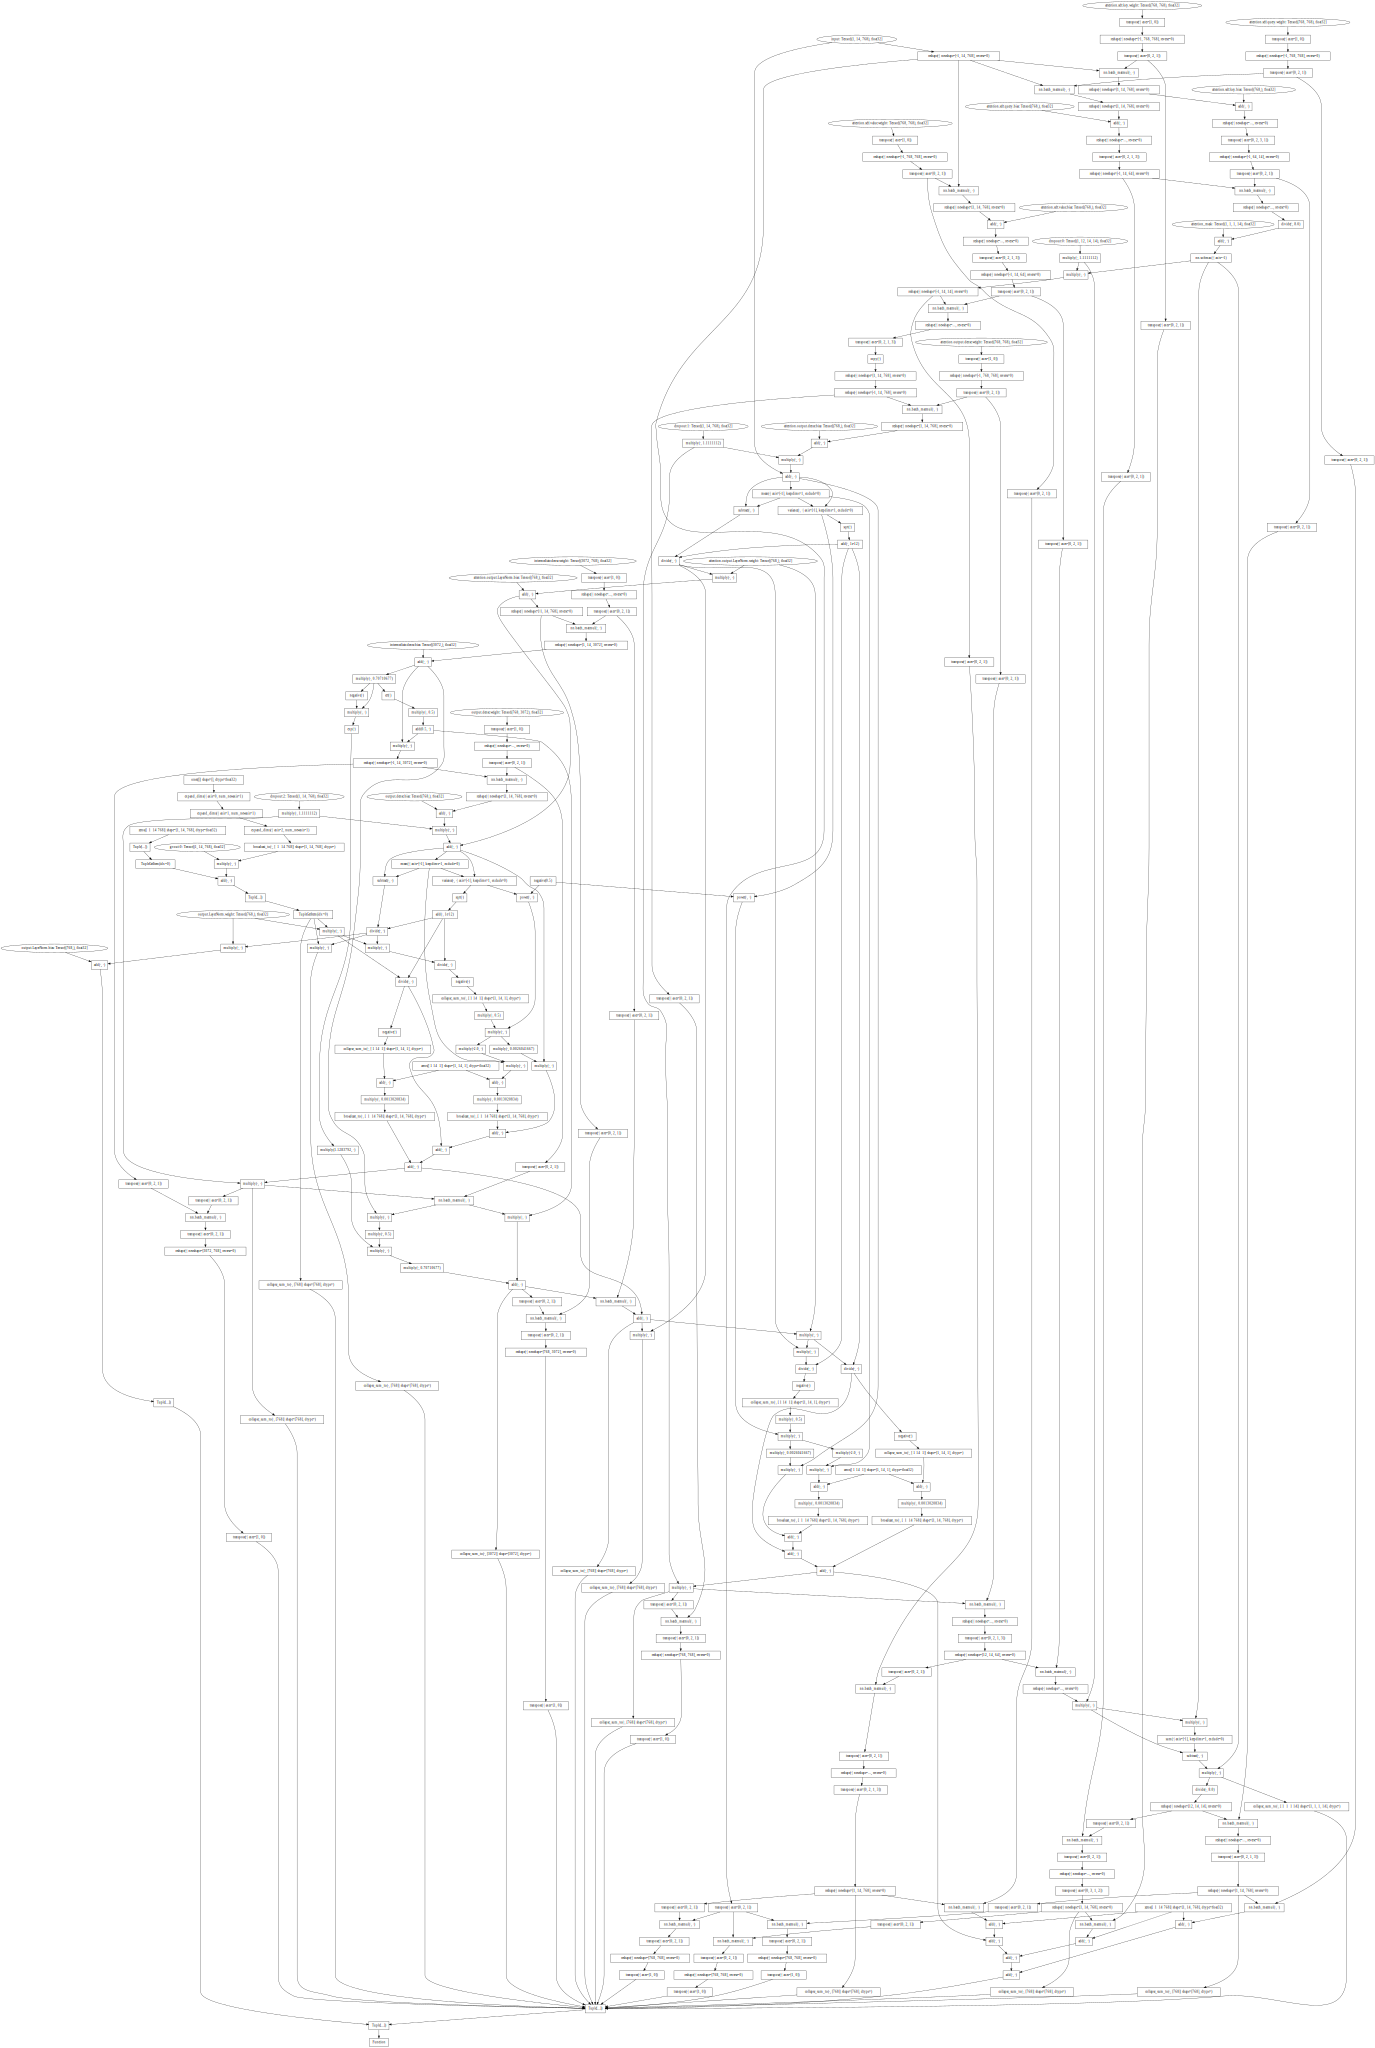

In [17]:
visualize(out_and_grad_fn)

But in PyTorch, we first compute the forward and then the backwards, so we have to take out the saw and 
split our graph. One of the difficult problems is what to do with things computed for both forward and backward. It is a hard problem, related to the MinCut problem.

Our extremal options could be:
- One could only keep the inputs and recompute everything as needed.
- If we had a salar output, we could compute the gradient and multiply with the derivative of the later layers on backward. (Loss functions might do that.) This does not, however, work for non-scalar tensor outputs.

We'll do the following: We compute the forward normally, but we keep all things that will be used in the backward. This is too much, unfortunately, and it is very likely the reason we don't see an end to end speedup. We'll discuss some potential heuristics below.

We use a coloring here. First we color all nodes of the forward computation in red. Then we traverse the gradient calculation and then color the nodes it needs from the backward blue. This gives us a chance to show off the attribute support in our visualization.

A bit of (PyTorch) terminology: When we have a function $Layer : x \mapsto y$ followed by some $Loss : y \mapsto l \in \mathbb{R}$, the backward is $BackwardOfLayer : grad\_out \mapsto grad\_in$ with $grad\_out = dl/dy$ and $grad\_in = dl/dx$.

In [18]:
orig_out = out_and_grad_fn.body.fields[0]
grad_ins = out_and_grad_fn.body.fields[1]

color_dict = {}
def color(n, c):
    if n in color_dict:
        return
    color_dict[n] = c
    for a in getattr(n, 'args', []):
        color(a, c)
    for a in getattr(n, 'fields', []):
        color(a, c)
    for nam in ('body', 'tuple_value'):
        b = getattr(n, nam, None)
        if b is not None:
            color(b, c)

color(orig_out, {'color': 'red'})
seen = set()
def color_crossings(n, c):
    if n in seen:
        return
    seen.add(n)
    if n in color_dict:
        color_dict[n] = c
        return
    for a in getattr(n, 'args', []):
        color_crossings(a, c)
    for a in getattr(n, 'fields', []):
        color_crossings(a, c)
    for nam in ('body', 'tuple_value'):
        b = getattr(n, nam, None)
        if b is not None:
            color_crossings(b, c)

color_crossings(grad_ins, {'color': 'blue'})



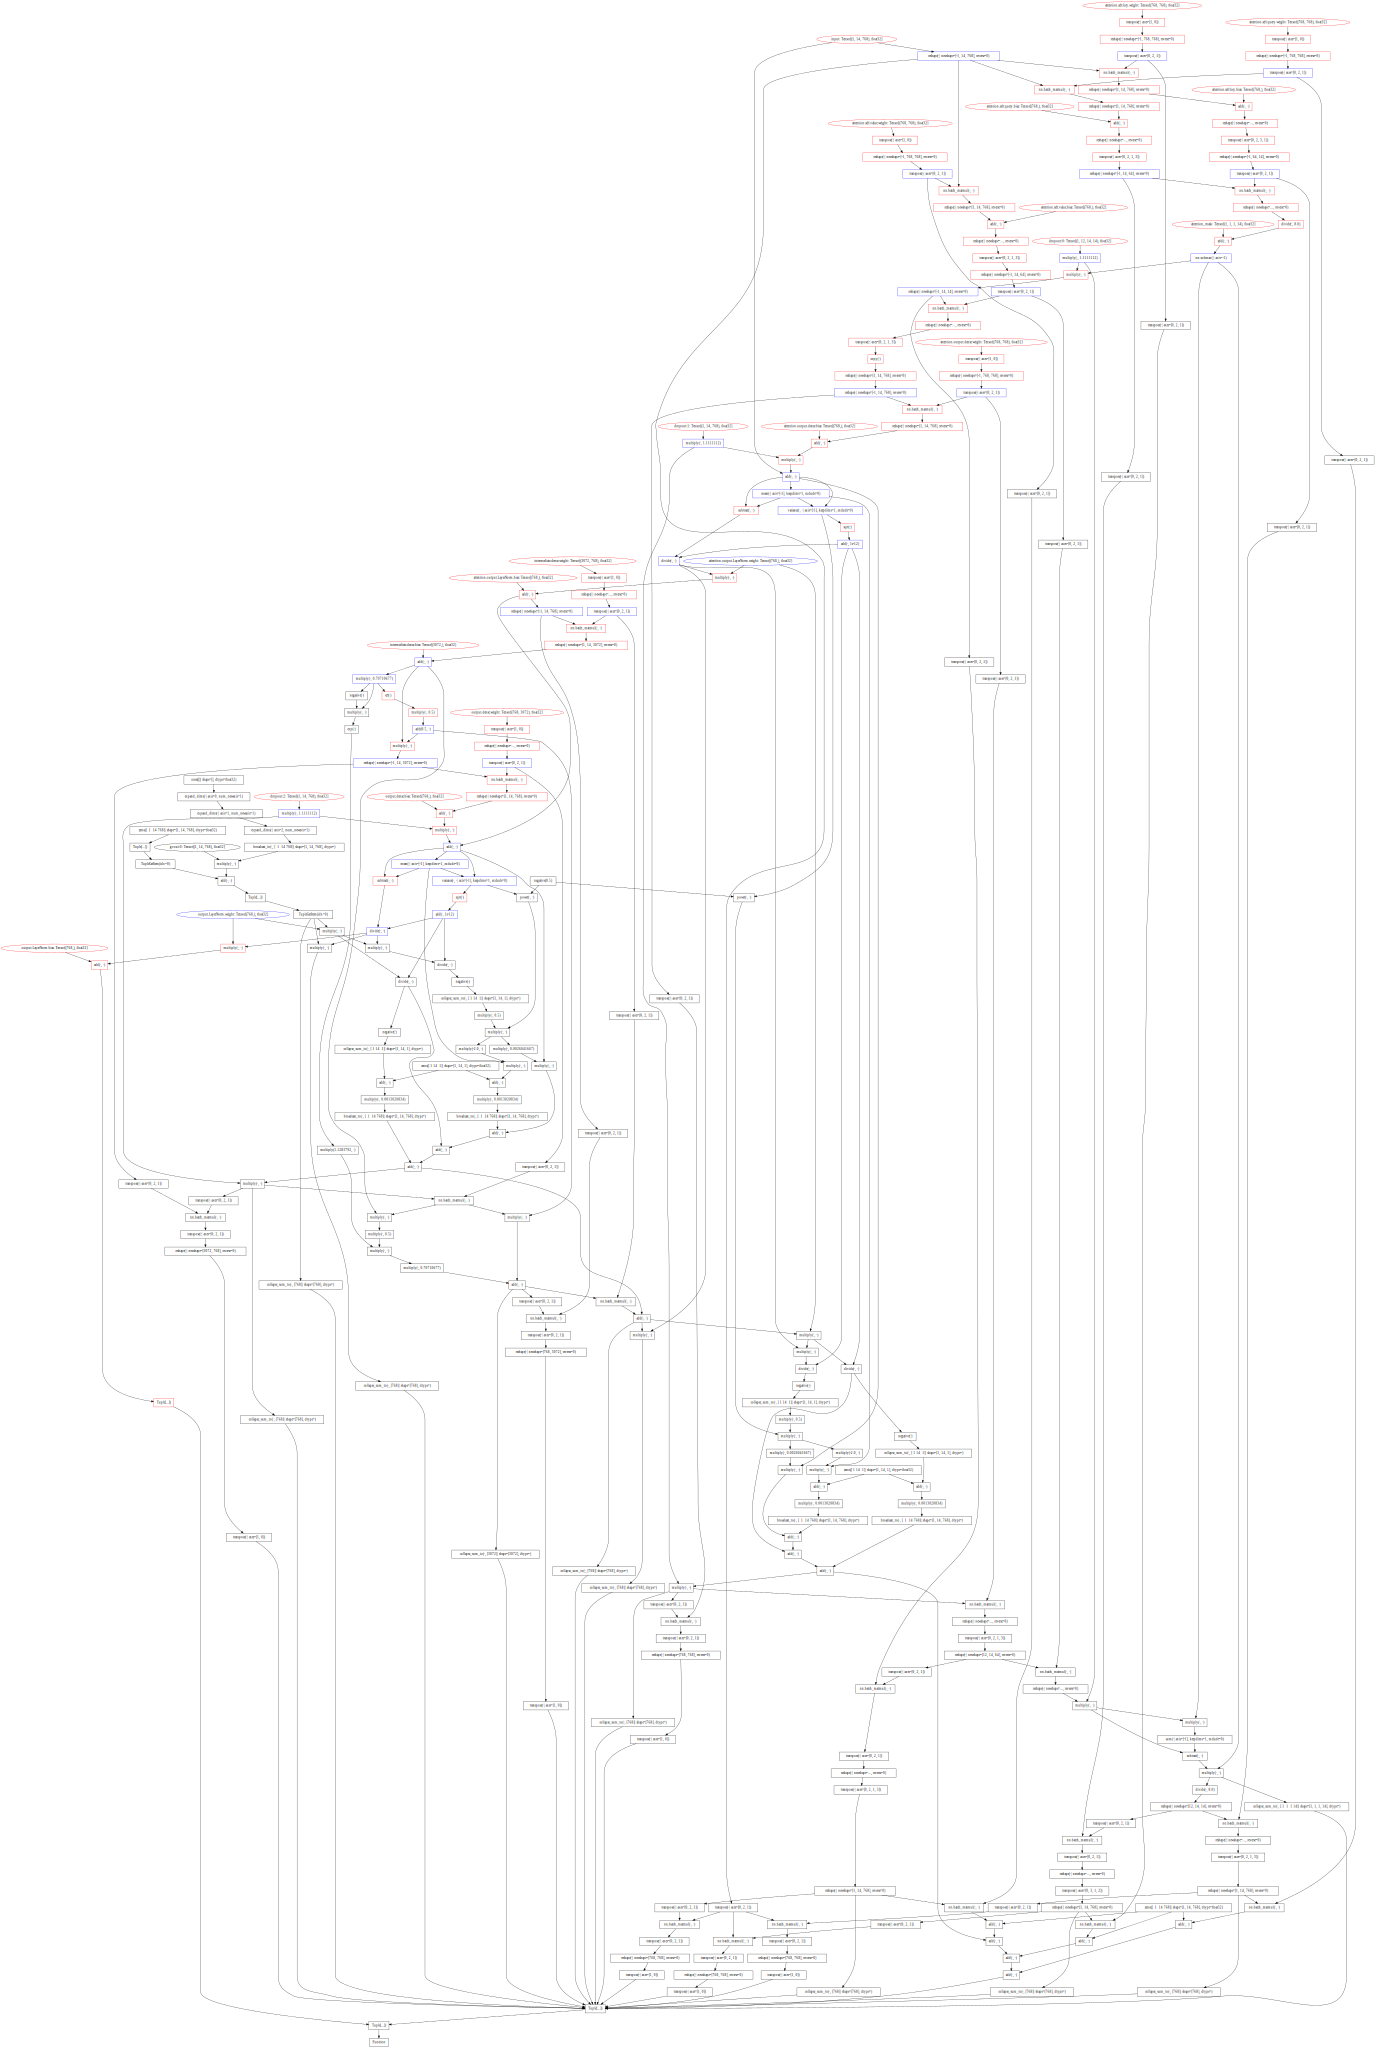

In [19]:
visualize(out_and_grad_fn, node_attr_dict=color_dict)

Now we can split the function as described above. We collect the blue nodes as to capture - but constants will
just be duplicated and inputs (`Var` nodes) need to be treated separately.

In [20]:
nodes_to_capture = [n for n, v in color_dict.items() 
                    if v['color'] == 'blue' and not isinstance(n, (tvm.relay.Constant, tvm.relay.Var))]
capture_tup = tvm.relay.Tuple(nodes_to_capture)
nodes_to_capture_idx = {n:i for i, n in enumerate(nodes_to_capture)}
capture_vars = [tvm.relay.var(f"input:captures:{i}", type_annotation=nodes_to_capture[i].checked_type)
                for i, n in enumerate(nodes_to_capture)]

grads_in = out_and_grad_fn.body.fields[1]

Now we can split out the backward, replacing all the blue nodes with variables.

In [21]:
needed_vars = set()
class GradientOnlyMutator(tvm.relay.ExprMutator):
    def __init__(self):
        super().__init__()

    def visit_var(self, var):
        needed_vars.add(var)
        return var

    def visit(self, expr):
        if expr in nodes_to_capture_idx:
            return capture_vars[nodes_to_capture_idx[expr]]
        return super().visit(expr)
    
grads_in_only = GradientOnlyMutator().visit(grads_in)
gr_only_fn = tvm.relay.Function(sorted(needed_vars) + capture_vars, grads_in_only)

# TODO: check against output of original
fn_for_gr_input_names = {p.name_hint for p in fn_for_gr.params}
needed_var_names = {v.name_hint for v in needed_vars}

assert needed_var_names <= fn_for_gr_input_names
inputs_to_keep = [n for n in needed_vars if not is_aux_input(n)]

Next we take the forward and amend it to also return the required intermediates.

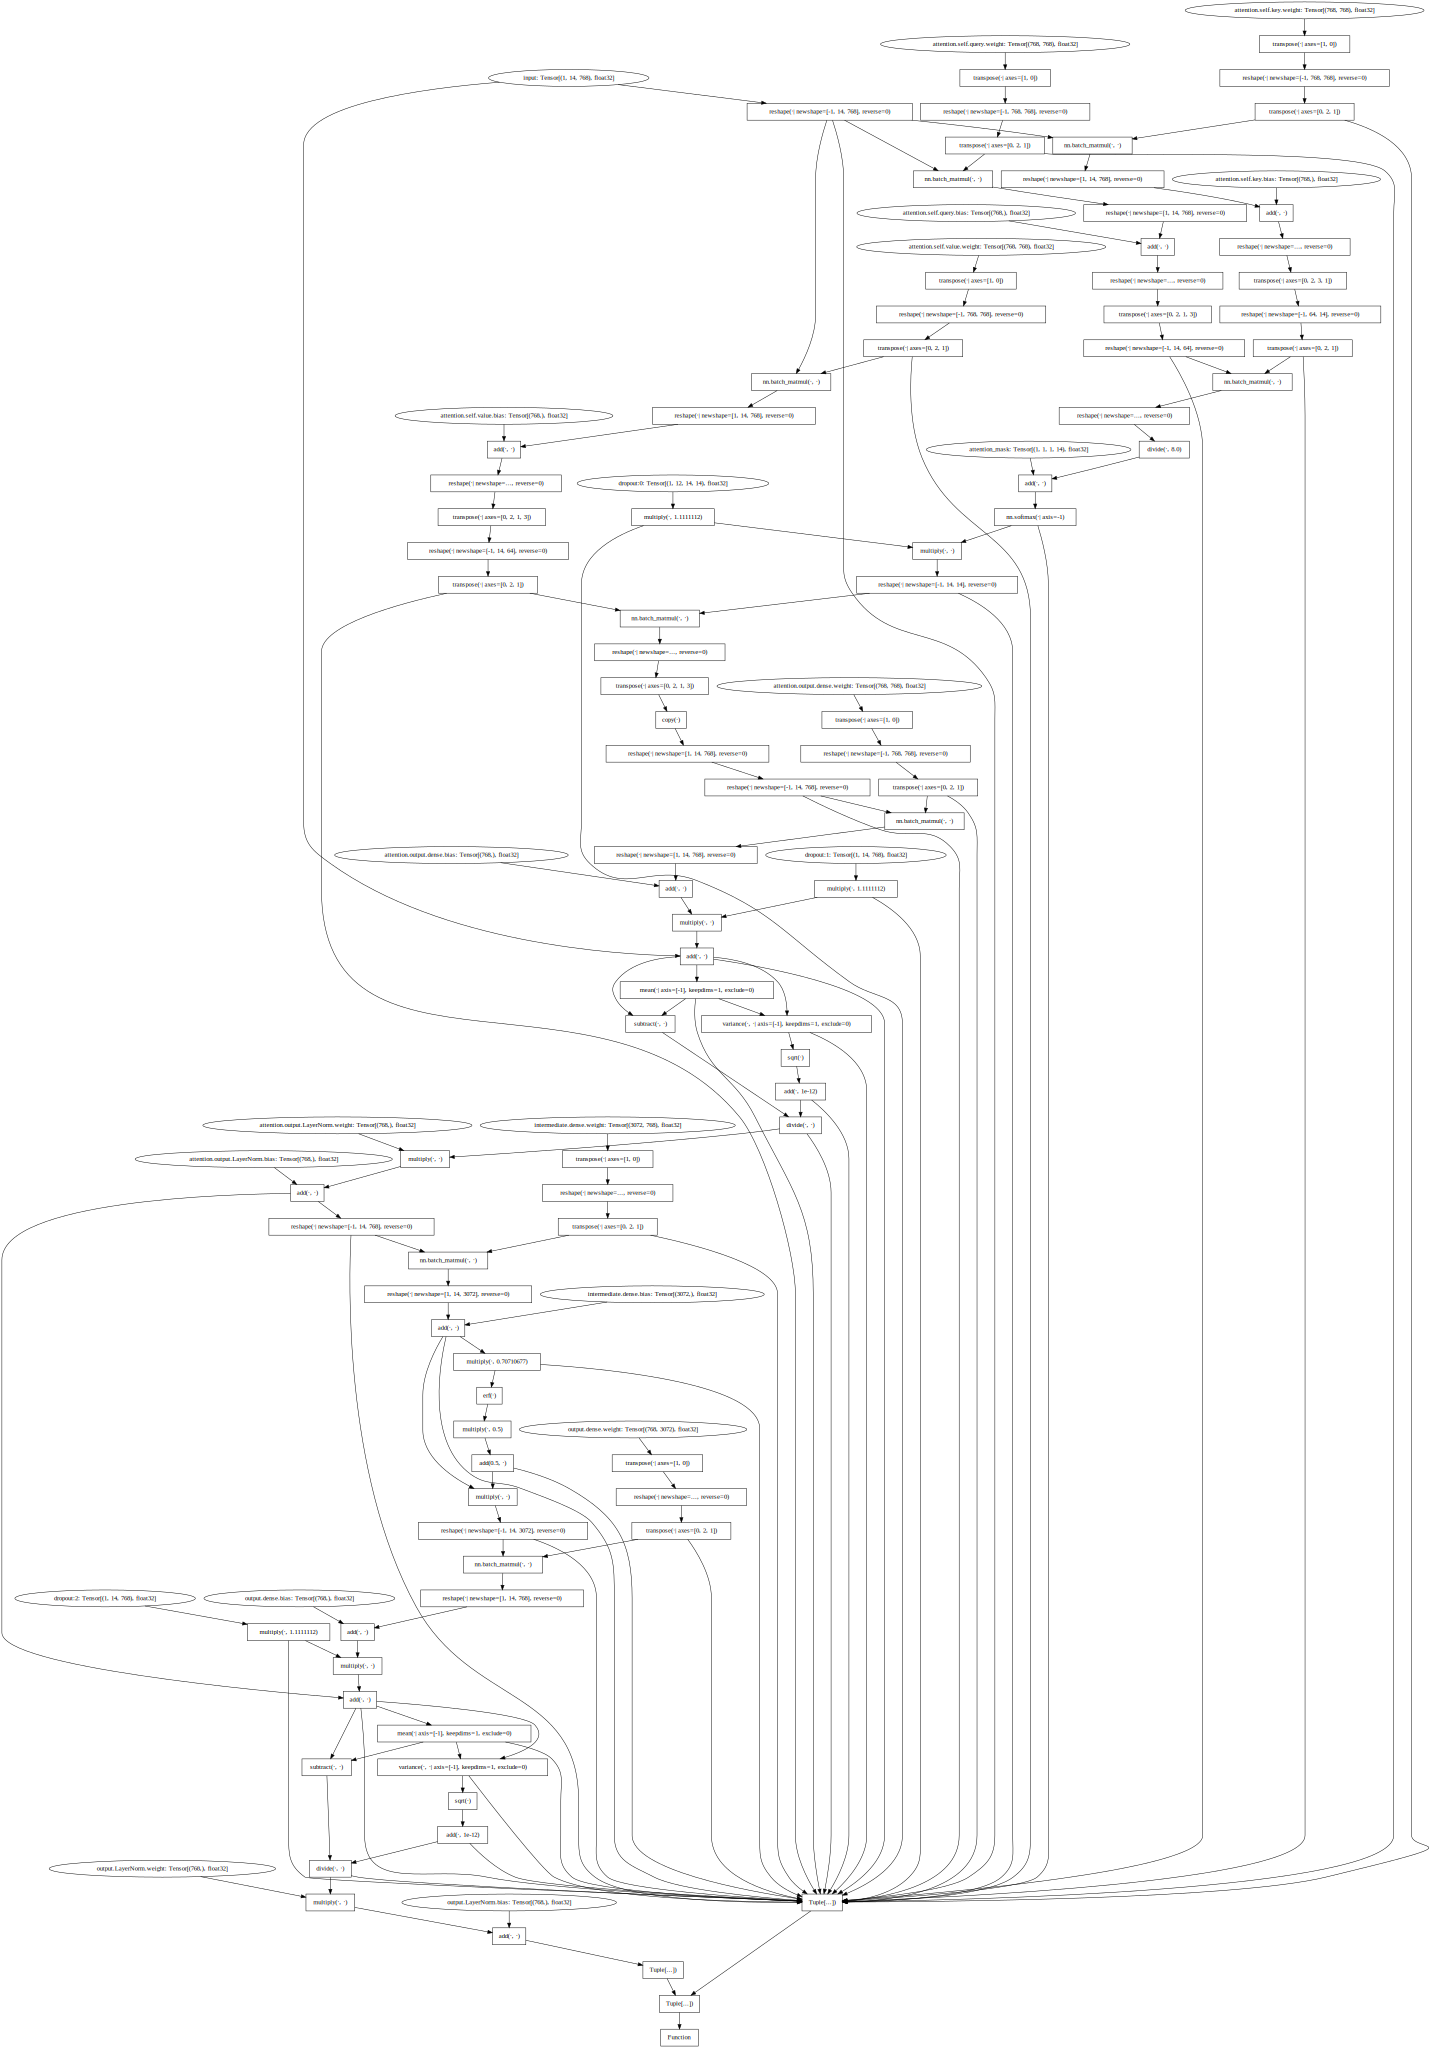

In [22]:
capture_tup = tvm.relay.Tuple([n for n in nodes_to_capture])
fw_and_cap_params = [p for p in out_and_grad_fn.params if not p.name_hint.startswith('gr:out:')]

fw_and_cap_fn = tvm.relay.Function(fw_and_cap_params,
                                   tvm.relay.Tuple((out_and_grad_fn.body.fields[0],) + (capture_tup,)))
visualize(fw_and_cap_fn)

TVM cannot return nested tuples, so we flatten the output in the function. Again we differentiate between tensor-valued functions and tuple valued ones (i.e. those returning potentially multiple tensors).

In [23]:
if isinstance(fn.body, tvm.relay.Tuple):
    # tuple of tensors output
    fw_and_cap_fn_flattened = tvm.relay.Function(fw_and_cap_fn.params, tvm.relay.Tuple(list(fw_and_cap_fn.body.fields[0].fields) # or single tensor
                                                + list(fw_and_cap_fn.body.fields[1].fields)))
else:
    # single tensor output
    fw_and_cap_fn_flattened = tvm.relay.Function(fw_and_cap_fn.params, tvm.relay.Tuple([fw_and_cap_fn.body.fields[0]]
                                                + list(fw_and_cap_fn.body.fields[1].fields)))


And at last, we can let TVM do its magic and compile our functions.

In [24]:
target = 'rocm -model=gfx906'
target_host = 'llvm'
ctx = tvm.context(target)

fw_and_cap_mod = tvm.IRModule({"main": fw_and_cap_fn_flattened})
with tvm.transform.PassContext(opt_level=3):
    graph, lib, params = tvm.relay.build(fw_and_cap_mod,
                                         target=target,
                                         target_host=target_host,
                                         params={})
fw_and_cap_compiled_module = tvm.contrib.graph_runtime.create(graph, lib, ctx)
fw_and_cap_compiled_module.set_input(**params)

gr_only_mod = tvm.IRModule({"main": gr_only_fn})
with tvm.transform.PassContext(opt_level=3):
    graph, lib, params = tvm.relay.build(gr_only_mod,
                                     target=target,
                                     target_host=target_host,
                                     params={})
gr_only_compiled_module = tvm.contrib.graph_runtime.create(graph, lib, ctx)
gr_only_compiled_module.set_input(**params) # we do have funny const tensors from TVM :/

Time to give it a spin. We define convenience functions to move tensors between PyTorch and TVM and get the model parameters as a TVM dictionary.

In [25]:
def tensor_to_tvm(t):
    return tvm.nd.from_dlpack(torch.utils.dlpack.to_dlpack(t))
def tensor_from_tvm(a):
    return(torch.utils.dlpack.from_dlpack(a.to_dlpack()))

debug_wrap.wrapped.cuda()
traced_module.cuda()

model_params_tvm = {k: tensor_to_tvm(v) for k, v in debug_wrap.wrapped.state_dict().items()}

Similarly, we get the inputs on the GPU in PyTorch and TVM.

In [26]:
inp_c = [i.cuda() for i in debug_wrap.DEBUG_INP[:2]]
inp_tvm = [tensor_to_tvm(i) for i in inp_c]


We need to deal with the dropout. It will turn out that our record of the dropout random draws happens in the same order as the dropout in the model. We did a depth-first search on the computational graph to find them and if the values of the the dropout are connected in the graph rather than being on independent branches, this will be the order in which PyTorch draws the matrices, too. If not, good luck fiddeling with the order.

In [27]:
dropout_info

{'dropout:0': (0.1, TensorType([1, 12, 14, 14], float32)),
 'dropout:1': (0.1, TensorType([1, 14, 768], float32)),
 'dropout:2': (0.1, TensorType([1, 14, 768], float32))}

In [28]:
torch.manual_seed(12345)
drop_c = {}
for k in dropout_info.keys(): # we don't know the order
    p, typ = dropout_info[k]
    drop_c[k] = torch.nn.functional.dropout(torch.ones([int(i) for i in typ.shape], 
                                              dtype=getattr(torch, typ.dtype), device="cuda"), p=p)*(1-p)

drop_tvm = {n: tensor_to_tvm(t) for n, t in drop_c.items()}

Now we can run the forward.

In [29]:
fw_and_cap_compiled_module.set_input('input', inp_tvm[0])
fw_and_cap_compiled_module.set_input('attention_mask', inp_tvm[1])
fw_and_cap_compiled_module.set_input(**model_params_tvm)
fw_and_cap_compiled_module.set_input(**drop_tvm)
fw_and_cap_compiled_module.run()

And we can compare the output to PyTorch's:

In [30]:
torch.manual_seed(12345)
debug_wrap.wrapped.train()
numpy.abs(fw_and_cap_compiled_module.get_output(0).asnumpy()-debug_wrap.wrapped(*inp_c)[0].detach().cpu().numpy()).max()

2.026558e-06

Supergood. Let's also try the backward. We generate a `grad_out`, set all the variables and run the backward model and run the backward model

In [31]:
gr_out_c = torch.randn(debug_wrap.DEBUG_OUT[0].shape, device="cuda", dtype=debug_wrap.DEBUG_OUT[0].dtype)

In [32]:
num_captures = len(capture_vars)
num_regular_outputs = len(fw_and_cap_fn_flattened.body.fields) - num_captures
captured_values = {v.name_hint: fw_and_cap_compiled_module.get_output(num_regular_outputs + i) for i, v in enumerate(capture_vars)}

#gr_only_compiled_module.set_input('input', inp_tvm[0])
#gr_only_compiled_module.set_input('attention_mask', inp_tvm[1])
gr_only_compiled_module.set_input(**drop_tvm)
gr_only_compiled_module.set_input(**model_params_tvm)
gr_only_compiled_module.set_input(**captured_values)
gr_only_compiled_module.set_input('gr:out:0', tensor_to_tvm(gr_out_c))
gr_only_compiled_module.run()

On the PyTorch side, it is easiest to re-run the forward (remembering to reset the random seed) and get the grads.

In [33]:
torch.manual_seed(12345)
debug_wrap.wrapped.train()
inp_c_rq = [i.requires_grad_() for i in inp_c]
for p in debug_wrap.wrapped.parameters():
    p.requires_grad_()
res = debug_wrap.wrapped(*inp_c_rq)[0]
grads_pt = torch.autograd.grad(res, inp_c_rq + list(debug_wrap.wrapped.parameters()), gr_out_c, allow_unused=True)


Did it work? It seems so:

In [34]:
for i, g_pt in enumerate(grads_pt):
    print(numpy.abs(gr_only_compiled_module.get_output(i).asnumpy() - g_pt.cpu().numpy()).max())

5.2452087e-06
1.001358e-05
6.4373016e-06
2.6226044e-06
1.1444092e-05
4.917383e-07
2.861023e-05
6.4373016e-06
1.335144e-05
6.198883e-06
6.556511e-06
4.172325e-06
6.866455e-05
3.33786e-06
8.821487e-06
1.9073486e-06
7.6293945e-06
1.9073486e-06


But we wanted to get something running in PyTorch, right?

Keeping with how PyTorch works, we first define an `autograd.Function` that the things we just did manually:
 
In the `forward`:

- Generate the dropout random values,
- Run the forward,
- Record the captures, inputs, and dropout values needed for backward.

In the `backward`, run the backward and return the result (as PyTorch tensors).


In [35]:
fw_input_names = [p.name_hint for p in fw_and_cap_fn_flattened.params if not is_aux_input(p)]
input_to_idx = {n:i for i, n in enumerate(fw_input_names)}
inputs_to_keep_idx = [input_to_idx[i.name_hint] for i in inputs_to_keep]


In [36]:
class TVMFunction(torch.autograd.Function):
    # nb. using the modules is not thread safe...
    @staticmethod
    def forward(ctx, *inputs):
        assert len(inputs) == len(fw_input_names)
        assert all([i.is_cuda for i in inputs])
        drop_c = {}
        for k in dropout_info.keys(): # we don't know the order
            p, typ = dropout_info[k]
            drop_c[k] = torch.nn.functional.dropout(torch.ones([int(i) for i in typ.shape], 
                                                      dtype=getattr(torch, typ.dtype), device="cuda"), p=p)*(1-p)

        # we don't need to worry about PyTorch changing these because they're not visible.
        # so we don't need save_for_backward here
        drop_tvm = {n: tensor_to_tvm(t) for n, t in drop_c.items()}
        ctx.drop_tvm = drop_tvm 

        fw_and_cap_compiled_module.set_input(**drop_tvm)

        inputs_tvm = [tensor_to_tvm(t) for t in inputs]
        for n, i in zip(fw_input_names, inputs_tvm):
            fw_and_cap_compiled_module.set_input(n, i)
        fw_and_cap_compiled_module.run()
        if isinstance(output_type, tvm.relay.TensorType):
            res = tensor_from_tvm(fw_and_cap_compiled_module.get_output(0))
            num_outputs = 1
        else:
            res = tuple(tensor_from_tvm(fw_and_cap_compiled_module.get_output(i))
                        for i in range(len(output_type.fields)))

            num_outputs = len(res)
        ctx.save_for_backward(*([inputs[i] for i in inputs_to_keep_idx]
                               +[tensor_from_tvm(fw_and_cap_compiled_module.get_output(i)) 
                                 for i in range(num_outputs, fw_and_cap_compiled_module.get_num_outputs())]))
        return res

    @staticmethod
    def backward(ctx, *grad_outs):
        saved = ctx.saved_tensors
        kept_inputs = {fw_input_names[i]: tensor_to_tvm(t)
                       for i, t in zip(inputs_to_keep_idx, saved[:len(inputs_to_keep_idx)])}
        gr_only_compiled_module.set_input(**kept_inputs)
        captures = {f'input:captures:{i}': tensor_to_tvm(t) for i, t in enumerate(saved[len(kept_inputs):])}
        gr_only_compiled_module.set_input(**captures)
        grad_outs_tvm = {f"gr:out:{i}": tensor_to_tvm(go) for i, go in enumerate(grad_outs)}
        gr_only_compiled_module.set_input(**grad_outs_tvm)
        gr_only_compiled_module.set_input(**ctx.drop_tvm)
        gr_only_compiled_module.run()
        grad_in = [tensor_from_tvm(gr_only_compiled_module.get_output(i)) for i in range(gr_only_compiled_module.get_num_outputs())]
        return tuple(grad_in)

Because calling `TVMFunction.apply` does not please the eye, we define a convenience function and because we always love to have proper signatures, we also give it the names of our inputs.

In [37]:
def tvm_fn(*inputs):
    return TVMFunction.apply(*inputs)

tvm_fn.__signature__ = inspect.signature(tvm_fn).replace(
    parameters=[inspect.Parameter(n.replace('.', '__'), inspect.Parameter.POSITIONAL_ONLY) 
                for n in fw_input_names])

Let's check everything still works.

In [38]:
inp_all = (inp_c_rq + list(traced_module.parameters()))

torch.manual_seed(12345)
res_tvm = tvm_fn(*inp_all)

grad_outs = tuple(torch.randn_like(r) for r in res_tvm)
grads_tvm = torch.autograd.grad(res_tvm, inp_all, grad_outs)

In [39]:
assert len(grads_tvm) == len(grads_pt)
list((g1-g2).abs().max().item() for g1, g2 in zip(grads_tvm, grads_pt))

[5.245208740234375e-06,
 1.0013580322265625e-05,
 6.4373016357421875e-06,
 2.6226043701171875e-06,
 1.1444091796875e-05,
 4.917383193969727e-07,
 2.86102294921875e-05,
 6.4373016357421875e-06,
 1.33514404296875e-05,
 6.198883056640625e-06,
 6.556510925292969e-06,
 4.172325134277344e-06,
 6.866455078125e-05,
 3.337860107421875e-06,
 8.821487426757812e-06,
 1.9073486328125e-06,
 7.62939453125e-06,
 1.9073486328125e-06]

Yay!

Let us wrap everything we did into a function that goes from traced model to autograd-wrapping function.


# End-to-end converter

In [43]:
def create_tvm_function_from_traced_module(traced_module):
    assert traced_model.training, "We only do training right now"
    dt = next(traced_module.parameters()).dtype.__str__().split('.')[-1]
    shape_list = [(i.debugName().split('.')[0], i.type().sizes()) for i in  list(traced_module.graph.inputs())[1:]]
    mod, mod_params = tvm.relay.frontend.pytorch.from_pytorch(traced_module, shape_list, default_dtype=dt)

    # the converter will output arguments in an arbitrary order (well, by position of use), we want that of the input
    fn = mod['main']
    # Careful traced module's vs. non-traced module's parameter ordering.
    # Anecdotally, I have not seen orderings differ between the two, though.
    arg_order = ([n for n, _ in shape_list]
                 +[n for n, _ in traced_module.named_parameters()])
    tmp_arg_idx = {p.name_hint: i for i, p in enumerate(fn.params)}

    fn = tvm.relay.Function([fn.params[tmp_arg_idx[n]] for n in arg_order], fn.body)

    fn = TransposeDedupMutator().visit(fn)

    # prepare function to also use grad_out
    fn = infer_type(fn)
    output_type = fn.body.checked_type # fn.ret_type :)

    if isinstance(output_type, tvm.relay.TensorType):
        gr_out = tvm.relay.var("gr:out", output_type)
        fn_for_gr = tvm.relay.Function(list(fn.params) + [gr_out], tvm.relay.sum(fn.body * gr_out))
    else:
        # we can try to handle tuples of tensors, but our nesting patience ends there
        assert (isinstance(output_type, tvm.relay.TupleType) and
                all([isinstance(f, tvm.relay.TensorType) for f in output_type.fields]))
        gr_outs = [tvm.relay.var(f"gr:out:{i}", t) for i, t in enumerate(output_type.fields)]
        prods_with_gr_out = [tvm.relay.sum(tvm.relay.TupleGetItem(fn.body, i) * go_i)
                             for i, go_i in enumerate(gr_outs)]
        s = prods_with_gr_out[0]
        for p in prods_with_gr_out[1:]:
            s = s + p
        fn_for_gr = tvm.relay.Function(list(fn.params) + gr_outs, s)
    fn_for_gr = infer_type(fn_for_gr)
    fn_for_gr = tvm.relay.dataflow_pattern.rewrite(DecomposeLayerNorm(), fn_for_gr)
    fn_for_gr = infer_type(fn_for_gr)
    fn_for_gr, dropout_info = externalize_dropout(fn_for_gr)
    fn_for_gr = infer_type(fn_for_gr)

    # take the gradient
    grfn = tvm.relay.transform.gradient(fn_for_gr, mode='first_order')
    grfn = to_graph_normal_form(grfn)

    # removing of unneeded outputs and simplifications of the gradient
    
    # Now we have (sum(orig_out * grad_out), (grad_inp_1, ..., grad_inp_n, grad_grad_out, gr_dropout ...))
    # but we only want orig_out and grad_inp_1, ..., grad_inp_n
    def is_aux_input(p):
        return p.name_hint.startswith('dropout:') or p.name_hint.startswith('gr:out:')

    # the gr_out and dropout parameters will have gradients computed, but we do not want that
    grads_to_keep = tvm.relay.Tuple([g for p, g in zip(grfn.params, grfn.body.fields[1].fields)
                                       if not is_aux_input(p)])

    assert grfn.body.fields[0].op.name == 'sum'
    assert grfn.body.fields[0].args[0].op.name == 'multiply'
    if isinstance(output_type, tvm.relay.TensorType):
        orig_out = grfn.body.fields[0].args[0].args[0]
    else:
        assert isinstance(output_type, tvm.relay.TupleType)
        orig_out = grfn.body.fields[0].args[0].args[0].tuple_value
    out_and_grad = tvm.relay.Tuple([orig_out, grads_to_keep])
    out_and_grad_fn = tvm.relay.Function(grfn.params, out_and_grad)
    out_and_grad_fn = infer_type(out_and_grad_fn)
    out_and_grad_fn = dead_code_elimination(out_and_grad_fn)
    out_and_grad_fn = eliminate_common_subexpr(out_and_grad_fn)
    out_and_grad_fn = infer_type(out_and_grad_fn)
    out_and_grad_fn = tvm.relay.dataflow_pattern.rewrite(LikeZapp(), out_and_grad_fn)
    out_and_grad_fn = infer_type(out_and_grad_fn)
    out_and_grad_fn = tvm.relay.dataflow_pattern.rewrite(ZeroZapp(), out_and_grad_fn)
    out_and_grad_fn = infer_type(out_and_grad_fn)
    out_and_grad_fn = tvm.relay.dataflow_pattern.rewrite(OneZapp(), out_and_grad_fn)
    out_and_grad_fn = infer_type(out_and_grad_fn)
    out_and_grad_fn = tvm.relay.dataflow_pattern.rewrite(OneZapp(), out_and_grad_fn)
    out_and_grad_fn = infer_type(out_and_grad_fn)
    out_and_grad_fn = dead_code_elimination(out_and_grad_fn)
    out_and_grad_fn = eliminate_common_subexpr(out_and_grad_fn)

    # split the graph into forward and backward

    orig_out = out_and_grad_fn.body.fields[0]
    grad_ins = out_and_grad_fn.body.fields[1]

    color_dict = {}
    def color(n, c):
        if n in color_dict:
            return
        color_dict[n] = c
        for a in getattr(n, 'args', []):
            color(a, c)
        for a in getattr(n, 'fields', []):
            color(a, c)
        for nam in ('body', 'tuple_value'):
            b = getattr(n, nam, None)
            if b is not None:
                color(b, c)

    color(orig_out, {'color': 'red'})
    seen = set()
    def color_crossings(n, c):
        if n in seen:
            return
        seen.add(n)
        if n in color_dict:
            color_dict[n] = c
            return
        for a in getattr(n, 'args', []):
            color_crossings(a, c)
        for a in getattr(n, 'fields', []):
            color_crossings(a, c)
        for nam in ('body', 'tuple_value'):
            b = getattr(n, nam, None)
            if b is not None:
                color_crossings(b, c)

    color_crossings(grad_ins, {'color': 'blue'})

    nodes_to_capture = [n for n, v in color_dict.items() 
                        if v['color'] == 'blue' and not isinstance(n, (tvm.relay.Constant, tvm.relay.Var))]
    capture_tup = tvm.relay.Tuple(nodes_to_capture)
    nodes_to_capture_idx = {n:i for i, n in enumerate(nodes_to_capture)}
    capture_vars = [tvm.relay.var(f"input:captures:{i}", type_annotation=nodes_to_capture[i].checked_type)
                    for i, n in enumerate(nodes_to_capture)]

    grads_in = out_and_grad_fn.body.fields[1]

    needed_vars = set()
    class GradientOnlyMutator(tvm.relay.ExprMutator):
        def __init__(self):
            super().__init__()

        def visit_var(self, var):
            needed_vars.add(var)
            return var

        def visit(self, expr):
            if expr in nodes_to_capture_idx:
                return capture_vars[nodes_to_capture_idx[expr]]
            return super().visit(expr)

    grads_in_only = GradientOnlyMutator().visit(grads_in)

    # TODO: check against output of original
    fn_for_gr_input_names = {p.name_hint for p in fn_for_gr.params}
    needed_var_names = {v.name_hint for v in needed_vars}
    gr_only_fn = tvm.relay.Function(sorted(needed_vars) + capture_vars, grads_in_only)
    assert needed_var_names <= fn_for_gr_input_names

    inputs_to_keep = [n for n in needed_vars if not is_aux_input(n)]

    # build the forward function that also returns the data for the backward
    capture_tup = tvm.relay.Tuple([n for n in nodes_to_capture])
    fw_and_cap_params = [p for p in out_and_grad_fn.params if not p.name_hint.startswith('gr:out:')]

    fw_and_cap_fn = tvm.relay.Function(fw_and_cap_params,
                                       tvm.relay.Tuple((out_and_grad_fn.body.fields[0],) + (capture_tup,)))

    if isinstance(fn.body, tvm.relay.Tuple):
        # tuple of tensors output
        fw_and_cap_fn_flattened = tvm.relay.Function(fw_and_cap_fn.params, tvm.relay.Tuple(list(fw_and_cap_fn.body.fields[0].fields) # or single tensor
                                                    + list(fw_and_cap_fn.body.fields[1].fields)))
    else:
        # single tensor output
        fw_and_cap_fn_flattened = tvm.relay.Function(fw_and_cap_fn.params, tvm.relay.Tuple([fw_and_cap_fn.body.fields[0]]
                                                    + list(fw_and_cap_fn.body.fields[1].fields)))

    target = 'rocm -model=gfx906'
    target_host = 'llvm'
    ctx = tvm.context(target)

    fw_and_cap_mod = tvm.IRModule({"main": fw_and_cap_fn_flattened})
    with tvm.transform.PassContext(opt_level=3):
        graph, lib, params = tvm.relay.build(fw_and_cap_mod,
                                             target=target,
                                             target_host=target_host,
                                             params={})
    fw_and_cap_compiled_module = tvm.contrib.graph_runtime.create(graph, lib, ctx)
    fw_and_cap_compiled_module.set_input(**params)

    gr_only_mod = tvm.IRModule({"main": gr_only_fn})
    with tvm.transform.PassContext(opt_level=3):
        graph, lib, params = tvm.relay.build(gr_only_mod,
                                         target=target,
                                         target_host=target_host,
                                         params={})
    gr_only_compiled_module = tvm.contrib.graph_runtime.create(graph, lib, ctx)
    gr_only_compiled_module.set_input(**params) # we may have funny const tensors from TVM

    fw_input_names = [p.name_hint for p in fw_and_cap_fn_flattened.params if not is_aux_input(p)]
    input_to_idx = {n:i for i, n in enumerate(fw_input_names)}
    inputs_to_keep_idx = [input_to_idx[i.name_hint] for i in inputs_to_keep]

    

    class TVMFunction(torch.autograd.Function):
        # nb. using the compiled_modules is not thread safe...
        @staticmethod
        def forward(ctx, *inputs):
            assert len(inputs) == len(fw_input_names)
            assert all([i.is_cuda for i in inputs])
            drop_c = {}
            for k in dropout_info.keys(): # we don't know the order
                p, typ = dropout_info[k]
                drop_c[k] = torch.nn.functional.dropout(torch.ones([int(i) for i in typ.shape], 
                                                          dtype=getattr(torch, typ.dtype), device="cuda"), p=p)*(1-p)

            # we don't need to worry about PyTorch changing these because they're not visible.
            # so we don't need save_for_backward here
            drop_tvm = {n: tensor_to_tvm(t) for n, t in drop_c.items()}
            ctx.drop_tvm = drop_tvm 

            fw_and_cap_compiled_module.set_input(**drop_tvm)

            inputs_tvm = [tensor_to_tvm(t) for t in inputs]
            for n, i in zip(fw_input_names, inputs_tvm):
                fw_and_cap_compiled_module.set_input(n, i)
            fw_and_cap_compiled_module.run()
            if isinstance(output_type, tvm.relay.TensorType):
                res = tensor_from_tvm(fw_and_cap_compiled_module.get_output(0))
                num_outputs = 1
            else:
                res = tuple(tensor_from_tvm(fw_and_cap_compiled_module.get_output(i))
                            for i in range(len(output_type.fields)))

                num_outputs = len(res)
            ctx.save_for_backward(*([inputs[i] for i in inputs_to_keep_idx]
                                   +[tensor_from_tvm(fw_and_cap_compiled_module.get_output(i)) 
                                     for i in range(num_outputs, fw_and_cap_compiled_module.get_num_outputs())]))
            return res

        @staticmethod
        def backward(ctx, *grad_outs):
            saved = ctx.saved_tensors
            kept_inputs = {fw_input_names[i]: tensor_to_tvm(t)
                           for i, t in zip(inputs_to_keep_idx, saved[:len(inputs_to_keep_idx)])}
            gr_only_compiled_module.set_input(**kept_inputs)
            captures = {f'input:captures:{i}': tensor_to_tvm(t) for i, t in enumerate(saved[len(kept_inputs):])}
            gr_only_compiled_module.set_input(**captures)
            grad_outs_tvm = {f"gr:out:{i}": tensor_to_tvm(go) for i, go in enumerate(grad_outs)}
            gr_only_compiled_module.set_input(**grad_outs_tvm)
            gr_only_compiled_module.set_input(**ctx.drop_tvm)
            gr_only_compiled_module.run()
            grad_in = [tensor_from_tvm(gr_only_compiled_module.get_output(i)) for i in range(gr_only_compiled_module.get_num_outputs())]
            return tuple(grad_in)

    def tvm_fn(*inputs):
        return TVMFunction.apply(*inputs)

    tvm_fn.__signature__ = inspect.signature(tvm_fn).replace(
        parameters=[inspect.Parameter(n.replace('.', '__'), inspect.Parameter.POSITIONAL_ONLY) 
                    for n in fw_input_names])
    return tvm_fn

Let's give it a spin and see that it hasn't stopped working.

In [44]:
tvm_fn = create_tvm_function_from_traced_module(traced_module)

ANTLR runtime and generated code versions disagree: 4.8!=4.7.2
ANTLR runtime and generated code versions disagree: 4.8!=4.7.2


In [45]:
inp_all = (inp_c_rq + list(traced_module.parameters()))
torch.manual_seed(12345)
res_tvm = tvm_fn(*inp_all)

grad_outs = tuple(torch.randn_like(r) for r in res_tvm)

grads_tvm = torch.autograd.grad(res_tvm, inp_all, grad_outs)

In [46]:
torch.manual_seed(12345)
res_pt = traced_module(*inp_c_rq)
grads_pt = torch.autograd.grad(res_pt, inp_all, grad_outs)

In [47]:
assert len(res_tvm) == len(res_pt) and len(grads_tvm) == len(grads_pt)
(list((r1-r2).abs().max().item() for r1, r2 in zip(res_tvm, res_pt)),
 list((g1-g2).abs().max().item() for g1, g2 in zip(grads_tvm, grads_pt)))

([2.0265579223632812e-06],
 [5.7220458984375e-06,
  1.33514404296875e-05,
  7.152557373046875e-06,
  3.039836883544922e-06,
  1.0728836059570312e-05,
  6.854534149169922e-07,
  3.24249267578125e-05,
  7.152557373046875e-06,
  1.33514404296875e-05,
  5.9604644775390625e-06,
  7.271766662597656e-06,
  4.291534423828125e-06,
  6.866455078125e-05,
  3.337860107421875e-06,
  8.821487426757812e-06,
  1.9073486328125e-06,
  7.62939453125e-06,
  1.9073486328125e-06])

# Even better: Auto-Dispatching to TVM

But we promised that we could have a function that takes a module and sample inputs and modifies the model to use
TVM if applicable.

Well, here it is, just a bit of messing with python method magic. For cleanliness, we also include a removal method.

In [48]:
def add_tvm_dispatch(module, sample_inputs):
    traced_module = torch.jit.trace(module, sample_inputs, )
    tvm_fn = create_tvm_function_from_traced_module(traced_module)
    tvm_input_shapes = [(i.shape, i.dtype, i.device) for i in sample_inputs]
    old_forward = module.forward
    old_remove_tvm_dispatch = getattr(module, 'remove_tvm_dispatch', None)


    def forward(self, *inputs):
        input_shapes = [(i.shape, i.dtype, i.device) for i in inputs]
        if tvm_input_shapes != input_shapes:
            res = old_forward(*inputs)
        else:
            inp_all = inputs + tuple(self.parameters())
            res = tvm_fn(*inp_all)
        return res

    def remove_tvm_dispatch(self):
        self.forward = old_forward
        if old_remove_tvm_dispatch is not None:
            self.remove_tvm_dispatch = old_remove_tvm_dispatch

    module.remove_tvm_dispatch = types.MethodType(remove_tvm_dispatch, module)
    module.forward = types.MethodType(forward, module)

All done!

Now let us run it for both a compatible input and an incompatible one. Notice the `grad_fn` printed at the end of the tensor output.

In [49]:
module = debug_wrap.wrapped
inp_c2 = [torch.cat([i, i], dim=0) for i in inp_c] # batch size 2 will be new

In [50]:
type(module)

transformers.modeling_bert.BertLayer

In [51]:
add_tvm_dispatch(module, inp_c)

/usr/local/lib/python3.8/dist-packages/torch/jit/_trace.py:954: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
With rtol=1e-05 and atol=1e-05, found 10752 element(s) (out of 10752) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference was 2.4348974227905273 (-2.1344871520996094 vs. -4.569384574890137), which occurred at index (0, 13, 381).
  _check_trace(


ANTLR runtime and generated code versions disagree: 4.8!=4.7.2
ANTLR runtime and generated code versions disagree: 4.8!=4.7.2


In [52]:
module.forward(*inp_c)

(tensor([[[ 0.2507, -0.2194, -0.1747,  ..., -0.0382,  0.0428,  0.1907],
          [-0.1018,  0.6621, -0.3244,  ...,  0.2131, -0.0591, -0.5416],
          [-0.3190, -0.5550,  0.0830,  ...,  0.0665,  0.2982,  0.1724],
          ...,
          [ 0.8956, -0.0658, -0.9987,  ...,  0.0883, -0.2493,  0.8897],
          [ 1.0403,  0.0970, -0.6477,  ...,  0.2595, -0.2993,  0.1683],
          [-0.2900,  0.1849,  0.1094,  ..., -0.3210,  0.4615,  0.0437]]],
        device='cuda:0', grad_fn=<TVMFunctionBackward>),)

In [53]:
module(*inp_c2)  # different shape

(tensor([[[ 0.1872, -0.2335, -0.1570,  ..., -0.0749,  0.0080,  0.2251],
          [-0.1784,  0.6730, -0.2436,  ...,  0.2280, -0.0746, -0.7620],
          [-0.5389, -0.6264, -0.1439,  ...,  0.1707,  0.2541,  0.1657],
          ...,
          [ 0.8209, -0.4704, -0.6749,  ..., -0.1276, -0.3264,  0.8429],
          [ 1.0422,  0.2161, -0.3209,  ...,  0.2026, -0.4514,  0.1065],
          [-0.2874,  0.1732,  0.0920,  ..., -0.2110,  0.5125,  0.0438]],
 
         [[ 0.2182, -0.2297, -0.1577,  ..., -0.0670,  0.0161,  0.2142],
          [-0.1877,  0.6781, -0.3514,  ...,  0.2637, -0.1320, -0.7478],
          [-0.4626, -0.7372,  0.0140,  ...,  0.1907,  0.1301,  0.2509],
          ...,
          [ 0.7453,  0.1160, -0.4402,  ..., -0.0357, -0.2483,  1.0130],
          [ 1.0437,  0.3303, -0.4749,  ...,  0.2047, -0.2310, -0.0612],
          [-0.2895,  0.2159,  0.1210,  ..., -0.1664,  0.5055, -0.0207]]],
        device='cuda:0', grad_fn=<NativeLayerNormBackward>),)

In [54]:
module.remove_tvm_dispatch()  # cleaning up

# Performance

As I said in the beginning, we aren't quite where we want to eventually be in terms of performance.
But let us tune the tasks a bit to see.

In [55]:
tasks1 = tvm.autotvm.task.extract_from_program(fw_and_cap_fn_flattened, target=target, params=params)
tasks2 = tvm.autotvm.task.extract_from_program(gr_only_mod["main"], target=target, params=params)


In [56]:
log_filename = 'bert-train-0.log'
n_trial = 20  # for real tuning, make this 2000!

def do_tune(tasks, log_filename):
    tmp_log_file = log_filename + ".tmp"
    for i, tsk in enumerate(reversed(tasks)):
        prefix = "[Task %2d/%2d] " %(i+1, len(tasks))

        # we use threading and tornado here to work around TVM and Jupyter colliding over IOLoops
        # In a regular python command line, you should be able to just call the tuner...
        import threading 
        import tornado

        # create tuner
        tuner = tvm.autotvm.tuner.XGBTuner(tsk, loss_type='rank')
        if os.path.isfile(tmp_log_file):
            tuner.load_history(tvm.autotvm.record.load_from_file(tmp_log_file))

        # do tuning
        tsk_trial = min(n_trial, len(tsk.config_space))
        def tune_task_fn():
            iol = tornado.ioloop.IOLoop()  # we need an event loop
            tuner.tune(
                n_trial=n_trial,
                early_stopping=600,
                measure_option=tvm.autotvm.measure_option(
                    builder=tvm.autotvm.LocalBuilder(timeout=10),
                    runner=tvm.autotvm.LocalRunner(number=20, repeat=3, timeout=4, min_repeat_ms=150)),
                callbacks=[
                    tvm.autotvm.callback.progress_bar(tsk_trial, prefix=prefix),
                    tvm.autotvm.callback.log_to_file(tmp_log_file)
                ])

        tuning_thread = threading.Thread(target=tune_task_fn)  # create a thread start it and wait on it
        tuning_thread.start()
        tuning_thread.join()
        # done tuning, on to the next task

    # pick best records to a cache file
    tvm.autotvm.record.pick_best(tmp_log_file, log_filename)

#do_tune(tasks1+tasks2, log_filename)

We build with our log.

In [57]:
with tvm.autotvm.apply_history_best(log_filename):
    tvm_fn = create_tvm_function_from_traced_module(traced_module)

ANTLR runtime and generated code versions disagree: 4.8!=4.7.2
ANTLR runtime and generated code versions disagree: 4.8!=4.7.2


In [58]:
def x():
    for i in range(100):
        res_tvm = tvm_fn(*inp_all)
        grads_tvm = torch.autograd.grad(res_tvm, inp_all, grad_outs)
    ctx.sync()

x()
%timeit x()

621 ms ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [60]:
def x():
    for i in range(100):
        res_pt = traced_module(*inp_c_rq)
        grads_pt = torch.autograd.grad(res_pt, inp_all, grad_outs)
    torch.cuda.synchronize()
x()
%timeit x()

126 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


So here it is. We ran our model through TVM all right. But it's not as fast as the usual method yet. Here is to opportunity!

More seriously, we have two things to improve performance:

- Find a better set of captured nodes.
- Find optimizations on the TVM graph.

In terms of heuristics for the former (remember that it quite likely NP hard, i.e. I believe it is, but I didn't work out a formal proof), one would want to re-do cheap computation, most prominently point-wise computation (or maybe anything but matmul?). But that is for another day.

I hope you enjoyed the tutorial, I look forward to your questions and comments at <tv@lernapparat.de>.